## 1. Install packages, GPU and Seed

In [1]:
# Standard Libraries
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import pickle

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToPILImage, ToTensor, RandomHorizontalFlip, RandomApply, GaussianBlur, ColorJitter
from torchvision.transforms.functional import affine, adjust_brightness, adjust_contrast, adjust_saturation
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.metrics import confusion_matrix

# Custom
from cust_functions.processing_helper import *
from cust_functions.models import *
from cust_functions.training_helper import *
from cust_functions.datavis_helper import *

In [2]:
print("Torch CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Torch CUDA available: True
Number of GPUs: 2
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1080 Ti


In [3]:
"""
Define seed
"""

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Data Analysis

### 2.1 Inspect the image labels visually

In [19]:
# print statisitcs of population density with missing values vs without missing values
pop_files_scaled = [f"{pop_path}/tile{i}_scaled.npy" for i in [0, 1, 3, 4]] + [f"{pop_path}/DAR_scaled.npy"]
image_names = ["Image 1", "Image 2", "Image 3", "Image 4", "DAR"]

stats = []
stats_without_missing = []

for idx, pop_file_scaled in enumerate(pop_files_scaled):
    pop_scaled = np.load(pop_file_scaled)

    # disregard -1 values
    stats.append([image_names[idx], pop_scaled.min(), pop_scaled.max(), pop_scaled.mean(), np.median(pop_scaled), pop_scaled.std()])
    pop_scaled = pop_scaled[pop_scaled != -1]
    stats_without_missing.append([image_names[idx], pop_scaled.min(), pop_scaled.max(), pop_scaled.mean(), np.median(pop_scaled), pop_scaled.std()])
    


stats_df = pd.DataFrame(stats, columns=["Image Name", "Min", "Max", "Mean","Median", "Std"])
stats_without_missing_df = pd.DataFrame(stats_without_missing, columns=["Image Name", "Min", "Max", "Mean", "Median", "Std"])

print("Population density statistics (original)")
print(stats_df)
print("\nPopulation density statistics (without missing values)")
print(stats_without_missing_df)

Population density statistics (original)
  Image Name  Min      Max      Mean  Median        Std
0    Image 1 -1.0  114.000  0.199635    -1.0   3.336955
1    Image 2 -1.0  184.875  0.464862    -1.0   5.321045
2    Image 3 -1.0  313.250 -0.219518    -1.0   4.544308
3    Image 4 -1.0  519.500  1.015477    -1.0  10.621991
4        DAR -1.0  955.000  5.712307    -1.0  35.678913

Population density statistics (without missing values)
  Image Name       Min      Max       Mean     Median        Std
0    Image 1  0.729980  114.000   5.116133   3.488281   5.167323
1    Image 2  0.740723  184.875   7.035150   3.972656  10.124919
2    Image 3  0.793945  313.250   8.436200   4.722656  12.961321
3    Image 4  0.940918  519.500  15.712941   7.144531  26.266973
4        DAR  0.691406  955.000  43.918690  13.257812  82.478287


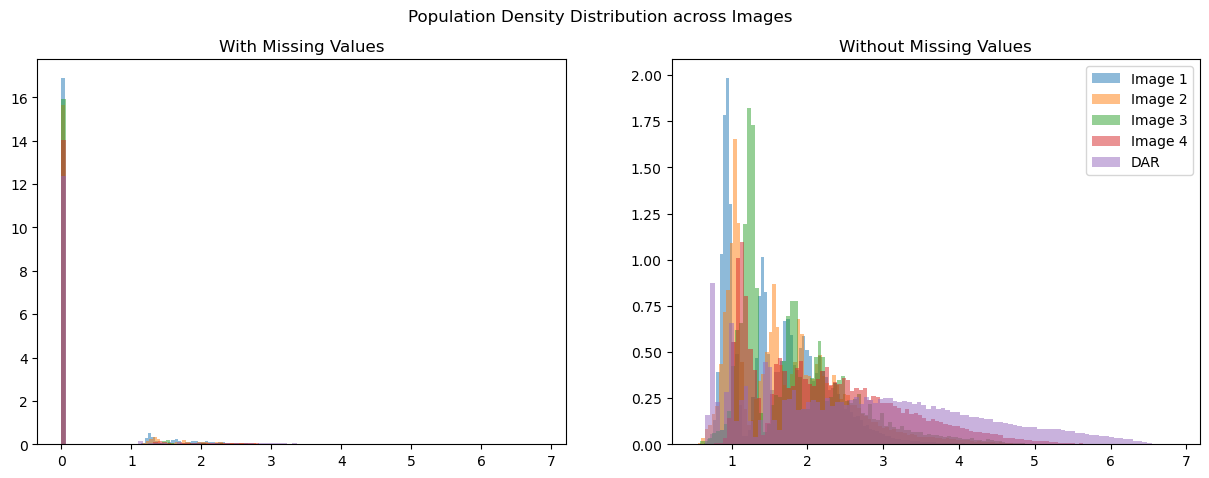

In [20]:
# Plot distribution of population density per image
pop_files_scaled = [f"{pop_path}/tile{i}_scaled.npy" for i in [0, 1, 3, 4]] + [f"{pop_path}/DAR_scaled.npy"]
image_names = ["Image 1", "Image 2", "Image 3", "Image 4", "DAR"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, pop_file in enumerate(pop_files_scaled):
    pop_f = np.load(pop_file)

    # Disregard -1 values
    pop_f_without = pop_f[pop_f != -1]

    # Apply log transformation
    pop_f_without = np.log(pop_f_without + 1)
    pop_f = np.log(pop_f + 2)

    # Plot histogram on the same axes
    axes[0].hist(pop_f.flatten(), bins=100, alpha=0.5, label=image_names[idx], density=True)
    axes[1].hist(pop_f_without.flatten(), bins=100, alpha=0.5, label=image_names[idx], density=True)

# Add title and labels
fig.suptitle("Population Density Distribution across Images")
axes[0].set_title("With Missing Values")
axes[1].set_title("Without Missing Values")

# Add legend
plt.legend()

# Show the plot
plt.show()


## 4. Model pipelines

### 4.1 Validation set creation

In [5]:
# File names with time steps
tile_lengths = {'tile0': 36, 'tile1': 26, 'tile3': 16, 'tile4': 22}
tiles = [0, 1, 3, 4]
base_path = "/home/pf/pfstud/mlarriere/aligned_data/"
blt_path = "/home/pf/pfstud/mlarriere/aligned_data/"
pop_path = "/home/pf/pfstud/mlarriere/aligned_data/pop_density/"

# create h5 files for all tiles
tile0 = [f"{base_path}tile0_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile0'])]
tile1 = [f"{base_path}tile1_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile1'])]
tile3 = [f"{base_path}tile3_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile3'])]
tile4 = [f"{base_path}tile4_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile4'])]
h5_files = tile0 + tile1 + tile3 + tile4

blt_files = []
for i, tile in enumerate(tiles):
    file_name = f"{blt_path}tile{tile}_aligned_BLT.h5"
    blt_files.extend([file_name] * tile_lengths[f'tile{tile}'])

file_names = {'CLD': 'CLD', 'RGB': 'RGB_cldgap', 'NIR': 'NIR_cldgap'}

pop_files_scaled = []
for i, tile in enumerate(tiles):
    file_name = f"{pop_path}tile{tile}_aligned_scaled.h5"
    pop_files_scaled.extend([file_name] * tile_lengths[f'tile{tile}'])


In [6]:
h5_files_cloudfree = [f"{base_path}tile{i}_aligned_cldmedian.h5" for i in [0, 1, 3, 4]]
blt_files_cloudfree = [f"{blt_path}tile{i}_aligned_BLT.h5" for i in [0, 1, 3, 4]]
pop_files_scaled_cloudfree = [f"{pop_path}tile{i}_aligned_scaled.h5" for i in [0, 1, 3, 4]]
file_names_cloudfree = {'RGB': 'RGB_cldmedian', 'NIR': 'NIR_cldmedian'}

In [6]:
# Define the validation dataset
dataset_cloudfree = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.05, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)
dataset_large = Smoothed_H5Dataset(h5_files, blt_files, pop_files_scaled, file_name=file_names, patch_size=(128, 128), blt_threshold = 0.05, cloud_free=False, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

In [7]:
# Split dataset cloud free into train and validation set
train_size = int(0.9 * len(dataset_cloudfree))
val_size = len(dataset_cloudfree) - train_size
train_dataset_cloudfree,  val_dataset_cloudfree = torch.utils.data.random_split(dataset_cloudfree, [train_size, val_size])

# Get small dataset for the pretrained model
val_pretraining_size = int(0.2 * len(val_dataset_cloudfree))
val_training_size = len(val_dataset_cloudfree) - val_pretraining_size
val_pretraining_dataset_cloudfree, val_training_dataset_cloudfree = torch.utils.data.random_split(val_dataset_cloudfree, [val_pretraining_size, val_training_size])

### Get indices of patch starts in dataset large ###
### 1. Training set ###
# Extract patch start points for validation set
val_patch_starts_cloudfree = [dataset_cloudfree.get_patch_starts()[idx] for idx in val_training_dataset_cloudfree.indices]

# get patch starts from dataset large from random time steps
val_patch_starts = []
for patch_start in val_patch_starts_cloudfree:
    if patch_start[0] == 0:
        # get random number between 0 and 35
        random_number = random.randint(0, 35)
        val_patch_starts.extend([(random_number, patch_start[1], patch_start[2])])
    elif patch_start[0] == 1:
        # get random number between 36 and 61
        random_number = random.randint(36, 61)
        val_patch_starts.extend([(random_number, patch_start[1], patch_start[2])])
    elif patch_start[0] == 2:
        # get random number between 62 and 77
        random_number = random.randint(62, 77)
        val_patch_starts.extend([(random_number, patch_start[1], patch_start[2])])
    elif patch_start[0] == 3:
        # get random number between 78 and 99
        random_number = random.randint(78, 99)
        val_patch_starts.extend([(random_number, patch_start[1], patch_start[2])])

# extract patch starts for validation set from dataset large
val_indices_large = dataset_large.get_indices_based_on_patch_starts(val_patch_starts)
val_dataset_large = torch.utils.data.Subset(dataset_large, val_indices_large)

### Get indices of patch starts in dataset large ###
### 2. Pre-Training set ###

# Extract patch start points for validation set
val_patch_starts_cloudfree = [dataset_cloudfree.get_patch_starts()[idx] for idx in val_pretraining_dataset_cloudfree.indices]

# get patch starts from dataset large from random time steps
val_patch_starts = []
for patch_start in val_patch_starts_cloudfree:
    if patch_start[0] == 0:
        # get random number between 0 and 35
        random_number = random.randint(0, 35)
        val_patch_starts.extend([(random_number, patch_start[1], patch_start[2])])
    elif patch_start[0] == 1:
        # get random number between 36 and 61
        random_number = random.randint(36, 61)
        val_patch_starts.extend([(random_number, patch_start[1], patch_start[2])])
    elif patch_start[0] == 2:
        # get random number between 62 and 77
        random_number = random.randint(62, 77)
        val_patch_starts.extend([(random_number, patch_start[1], patch_start[2])])
    elif patch_start[0] == 3:
        # get random number between 78 and 99
        random_number = random.randint(78, 99)
        val_patch_starts.extend([(random_number, patch_start[1], patch_start[2])])

# extract patch starts for validation set from dataset large
val_indices_large = dataset_large.get_indices_based_on_patch_starts(val_patch_starts)
val_dataset_large_pretraining  = torch.utils.data.Subset(dataset_large, val_indices_large)


### 4.2 Pretraining Build-up Model

In [19]:
dataset_pretrain = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.00, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)
pretrain_training_dataset = torch.utils.data.Subset(dataset_pretrain, list(set(range(len(dataset_pretrain))) - set(val_dataset_cloudfree.indices)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
blt_lr = 0.002
weight_decay = 0.0001
batch_size = 16

train_dataloader = DataLoader(pretrain_training_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader_cloudfree = DataLoader(val_pretraining_dataset_cloudfree, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader_large = DataLoader(val_dataset_large_pretraining, batch_size=batch_size, shuffle=False, num_workers=8)
blt_model = Unet_BLT(NUM_CHANNELS, NUM_CLASSES)
blt_model.to(device)
blt_model = nn.DataParallel(blt_model)

weights = torch.tensor([1.0, 1.5]).to(device)  
blt_loss = nn.CrossEntropyLoss(weight=weights)

blt_optimizer = torch.optim.Adam(blt_model.parameters(), lr=blt_lr, weight_decay=weight_decay)
blt_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(blt_optimizer, mode='min', factor=0.25, patience=10)

results = {
    "train_loss": [],
    "val_loss": [],
}

best_val_loss = np.inf
best_model = None
patience = 10


# Train model
for epoch in range(num_epochs):

    # train model
    running_train_loss = train_blt_model(blt_model, blt_optimizer, blt_loss, train_dataloader, device, NUM_CLASSES)

    # Validate model cloud free
    running_val_loss = validate_blt_model(blt_model, blt_loss, val_dataloader_cloudfree, device, NUM_CLASSES)

    # Validate model cloudy
    running_val_loss += validate_blt_model(blt_model, blt_loss, val_dataloader_large, device, NUM_CLASSES)

    # Calculate epoch metrics
    epoch_train_loss = running_train_loss / len(train_dataloader)
    epoch_val_loss = running_val_loss / (len(val_dataloader_cloudfree) + len(val_dataloader_large))

     # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model = blt_model.state_dict().copy()
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break


    # Udpate results dictionary
    results["train_loss"].append(epoch_train_loss)
    results["val_loss"].append(epoch_val_loss)

    print(f"Epoch {epoch+1} train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}")
    
    # Update learning rate
    blt_scheduler.step(epoch_val_loss)

# Save model
PATH = f"Unet_BLT_pretrained.pth"
torch.save(best_model, PATH)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
PATH = "Unet_BLT_pretrained.pth"

# load model
model = load_blt_model(Unet_BLT, PATH, device, NUM_CHANNELS, NUM_CLASSES)

# Get dataset
dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_pretraining_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_pretraining_dataset_cloudfree.indices)


# get 50 random validation patches
random_indices = random.sample(range(len(dataset_seperated)), 50)

# Plot prediction and ground truth overlayed on rgb image
for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_blt_patch(model, dataset_for_prediction, i, device)
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()
    plot_with_overlays(rgb, blt_truth, blt=None, predictions=[pred], model_names = ['Unet_BLT_pretrained'])



### 4.3 Early fusion

#### 4.3.1 No mask

In [8]:
dataset_no_mask = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.15, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)
train_dataset_no_mask = torch.utils.data.Subset(dataset_no_mask, list(set(range(len(dataset_no_mask))) - set(val_dataset_cloudfree.indices)))

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
pop_lr = 0.05
weight_decay = 0.0001
batch_size = 16

train_dataloader = DataLoader(train_dataset_no_mask, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader_cloudfree = DataLoader(val_training_dataset_cloudfree, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader_large = DataLoader(val_dataset_large, batch_size=batch_size, shuffle=False, num_workers=8)

blt_model = Unet_BLT(NUM_CHANNELS, NUM_CLASSES)
pop_model = Unet_pop_2layer(NUM_CHANNELS)
pop_model.to(device)
pop_model = nn.DataParallel(pop_model)
 
custom_mse_loss = nn.MSELoss() #CustomMSELoss(alpha=1.0, beta=0.5, gamma=0.0, near_zero_threshold=0.01, overprediction_threshold = 1.5).to(device)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
mae_weight = 0.1
mse_weight = 0.9

pop_optimizer = torch.optim.Adam(pop_model.parameters(), lr=pop_lr, weight_decay=weight_decay)
pop_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pop_optimizer, mode='min', factor=0.5, patience=5)

train_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

val_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

best_val_loss = np.inf
best_pop_model = None
best_epoch = 0

patience = 15


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_mae_train_loss, running_mse_train_loss, running_custom_mse_train = train_model(blt_model, pop_model, pop_optimizer, custom_mse_loss, mae_loss, mse_loss, train_dataloader, 
                                                                                           device, mask = None, train_blt = False, mae_weight=mae_weight, mse_weight=mse_weight)

    # Validate model cloud free
    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_cloudfree, device, mask=None)

    # Validate model cloudy
    running_mae_val_loss_cloudy, running_mse_val_loss_cloudy, running_custom_mse_val_cloudy = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_large, device, mask=None)

    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = running_mae_val_loss + running_mae_val_loss_cloudy, running_mse_val_loss + running_mse_val_loss_cloudy, running_custom_mse_val + running_custom_mse_val_cloudy

    # Calculate epoch metrics
    epoch_mae_train_loss = running_mae_train_loss / len(train_dataloader)
    epoch_rmse_train_loss = np.sqrt(running_mse_train_loss / len(train_dataloader))
    epoch_custom_rmse_train_loss = np.sqrt(running_custom_mse_train / len(train_dataloader))

    epoch_mae_val_loss = running_mae_val_loss / (len(val_dataloader_cloudfree) + len(val_dataloader_large))
    epoch_rmse_val_loss = np.sqrt(running_mse_val_loss / (len(val_dataloader_cloudfree)  + len(val_dataloader_large)))
    epoch_custom_rmse_val_loss = np.sqrt(running_custom_mse_val / (len(val_dataloader_cloudfree) + len(val_dataloader_large)))


    epoch_loss = mae_weight * epoch_mae_val_loss + mse_weight * epoch_rmse_val_loss

     # Early stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss 
        best_pop_model = pop_model.state_dict().copy()
        best_blt_model = blt_model.state_dict().copy()
        best_epoch = epoch
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Udpate results dictionary
    train_results["mae_loss"].append(epoch_mae_train_loss)
    train_results["rmse"].append(epoch_rmse_train_loss)
    train_results["custom_rmse"].append(epoch_custom_rmse_train_loss)

    val_results["mae_loss"].append(epoch_mae_val_loss)
    val_results["rmse"].append(epoch_rmse_val_loss)
    val_results["custom_rmse"].append(epoch_custom_rmse_val_loss)

    # print results
    print(f"Epoch {epoch+1} train MAE: {epoch_mae_train_loss:.4f}, train RMSE: {epoch_rmse_train_loss:.4f}, train custom RMSE {epoch_custom_rmse_train_loss:.4f}, val MAE: {epoch_mae_val_loss:.4f}, val RMSE: {epoch_rmse_val_loss:.4f}, val custom RMSE {epoch_custom_rmse_val_loss:.4f}")

    # Update learning rate
    pop_scheduler.step(epoch_loss)
    print("Learning rate:", pop_scheduler._last_lr)

# Save model
PATH = f"Unet_pop_no_mask.pth"
torch.save(best_pop_model, PATH)

In [38]:
#plot_metrics(train_results, val_results)
print(f"Best epoch: {best_epoch+1}")
print(f"Best MAE: {val_results['mae_loss'][best_epoch]:.4f}")
print(f"Best RMSE: {val_results['rmse'][best_epoch]:.4f}")

Best epoch: 38
Best MAE: 0.1016
Best RMSE: 0.1436


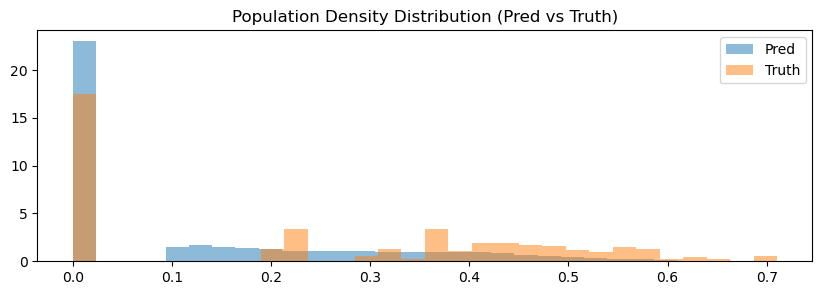

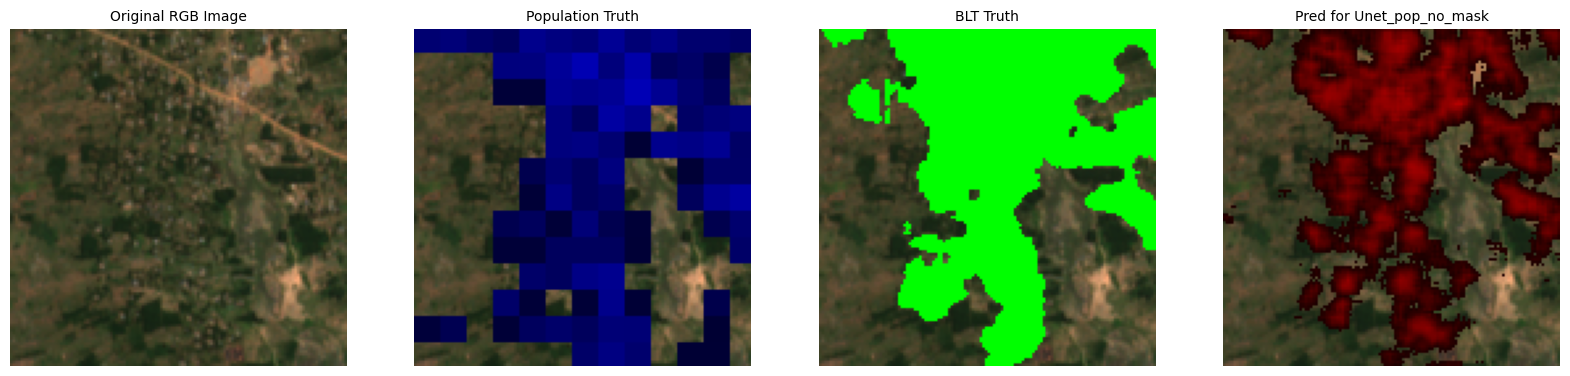

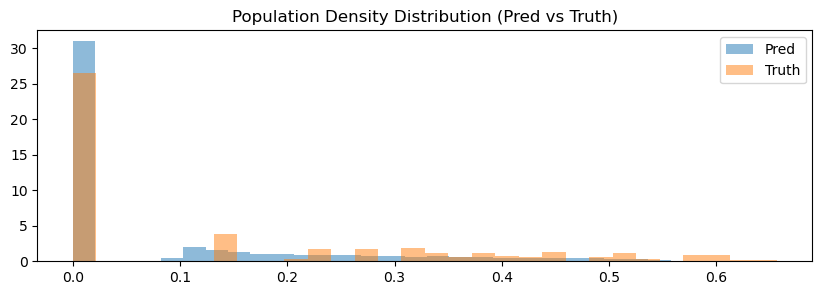

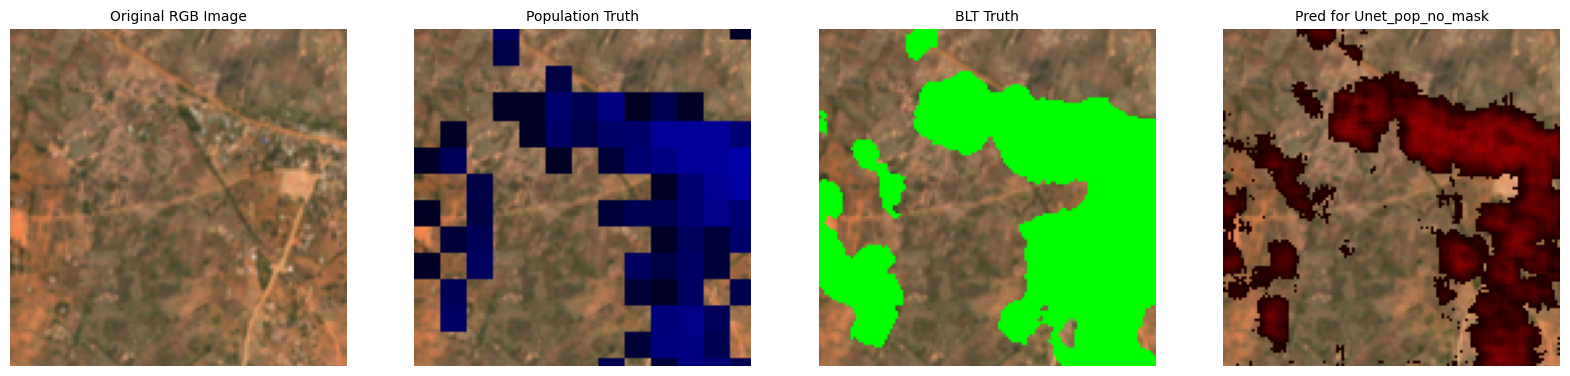

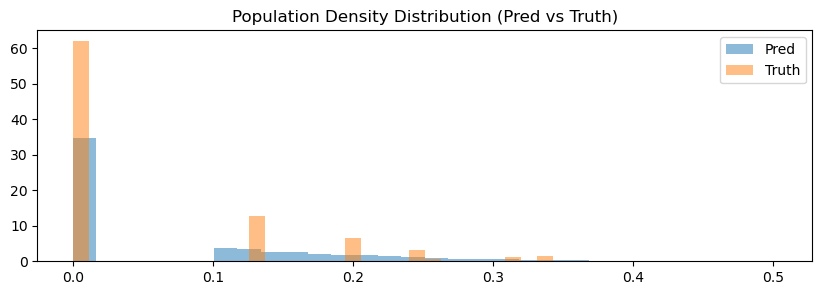

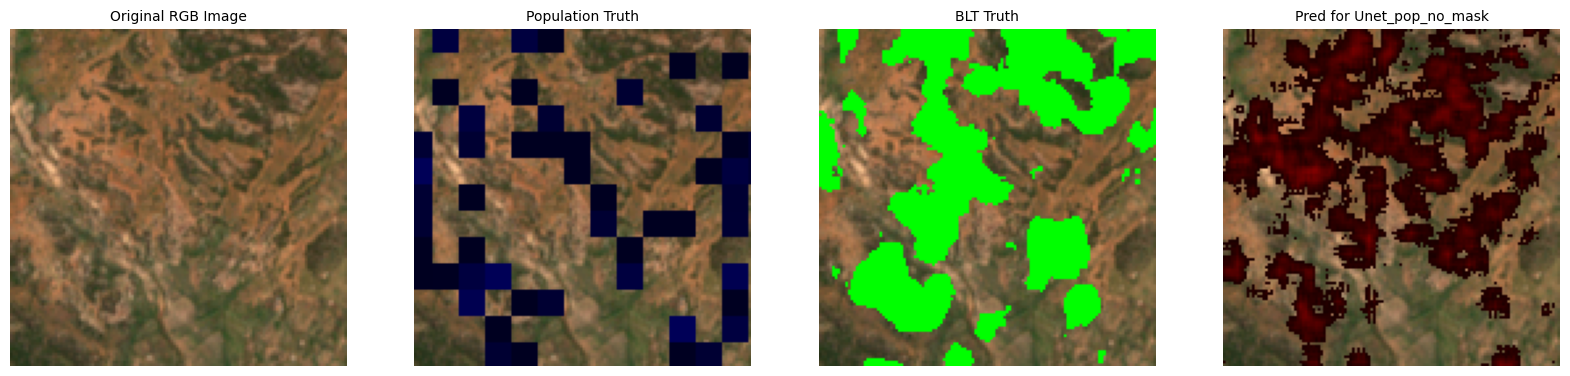

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
PATH2 = "saved_models/Unet_pop_no_mask_early.pth"
pop_model = load_pop_model(Unet_pop_2layer, PATH2, device, NUM_CHANNELS)

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_patch(pop_model, dataset_for_prediction, i, device, blt_model=None, mask=None).detach().squeeze(0).squeeze(0).cpu().numpy()
    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    # plot histogram of population density pred and truth
    plt.figure(figsize=(10, 3))
    plt.hist(pred.flatten(), bins=30, alpha=0.5, label="Pred", density=True)
    plt.hist(pop_truth.flatten(), bins=30, alpha=0.5, label="Truth", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=blt_truth, predictions=[pred], model_names = ['Unet_pop_no_mask'])


#### 4.3.2 Hard mask

In [10]:
dataset_hard = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.1, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)
train_dataset_hard= torch.utils.data.Subset(dataset_hard, list(set(range(len(dataset_hard))) - set(val_dataset_cloudfree.indices)))

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
pop_lr = 0.02
weight_decay = 0.0001
batch_size = 16

train_dataloader = DataLoader(train_dataset_hard, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader_cloudfree = DataLoader(val_training_dataset_cloudfree, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader_large = DataLoader(val_dataset_large, batch_size=batch_size, shuffle=False, num_workers=8)
PATH = "Unet_BLT_pretrained.pth"
blt_model = load_blt_model(Unet_BLT, PATH, device, NUM_CHANNELS, NUM_CLASSES)
pop_model = Unet_pop_2layer(NUM_CHANNELS)
blt_model.to(device)
pop_model.to(device)
pop_model = nn.DataParallel(pop_model)

weights = torch.tensor([1.0, 1.0]).to(device)  
blt_loss = nn.CrossEntropyLoss(weight=weights)
custom_mse_loss = nn.MSELoss() #CustomMSELoss().to(device)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
mae_weight = 0.05
mse_weight = 0.95
blt_weight = 1.0

#custom_loss_func = CustomPopulationLoss(weight_non_zero=2.0, weight_zero=1.0)
pop_optimizer = torch.optim.Adam(pop_model.parameters(), lr=pop_lr, weight_decay=weight_decay)
pop_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pop_optimizer, mode='min', factor=0.25, patience=3)

train_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

val_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

best_val_loss = np.inf
best_pop_model = None
best_blt_model = None
best_epoch = 0

patience = 15


# Train model
for epoch in range(num_epochs):
    

    # train model
    running_mae_train_loss, running_mse_train_loss, running_custom_mse_train = train_model(blt_model, pop_model, pop_optimizer, custom_mse_loss, mae_loss, mse_loss, train_dataloader, 
                                                                                                                                            device, blt_loss_func = blt_loss, mask="Hard", train_blt = False, mae_weight=mae_weight, 
                                                                                                                                             mse_weight=mse_weight)
    # Validate model
    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_cloudfree, device,  mask="Hard")

    # Validate model cloudy
    running_mae_val_loss_cloudy, running_mse_val_loss_cloudy, running_custom_mse_val_cloudy = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_large, device, mask="Hard")

    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = running_mae_val_loss + running_mae_val_loss_cloudy, running_mse_val_loss + running_mse_val_loss_cloudy, running_custom_mse_val + running_custom_mse_val_cloudy

 
    # Calculate epoch metrics
    epoch_mae_train_loss = running_mae_train_loss / len(train_dataloader)
    epoch_rmse_train_loss = np.sqrt(running_mse_train_loss / len(train_dataloader))
    epoch_custom_rmse_train_loss = np.sqrt(running_custom_mse_train / len(train_dataloader))

    epoch_mae_val_loss = running_mae_val_loss / (len(val_dataloader_cloudfree) + len(val_dataloader_large))
    epoch_rmse_val_loss = np.sqrt(running_mse_val_loss / (len(val_dataloader_cloudfree)  + len(val_dataloader_large)))
    epoch_custom_rmse_val_loss = np.sqrt(running_custom_mse_val / (len(val_dataloader_cloudfree) + len(val_dataloader_large)))

    epoch_loss = mae_weight * epoch_mae_val_loss + mse_weight * epoch_rmse_val_loss

     # Early stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss 
        best_pop_model = pop_model.state_dict().copy()
        best_blt_model = blt_model.state_dict().copy()
        best_epoch = epoch
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Udpate results dictionary
    train_results["mae_loss"].append(epoch_mae_train_loss)
    train_results["rmse"].append(epoch_rmse_train_loss)
    train_results["custom_rmse"].append(epoch_custom_rmse_train_loss)

    val_results["mae_loss"].append(epoch_mae_val_loss)
    val_results["rmse"].append(epoch_rmse_val_loss)
    val_results["custom_rmse"].append(epoch_custom_rmse_val_loss)

    # print results
    print(f"Epoch {epoch+1} train MAE: {epoch_mae_train_loss:.4f}, train RMSE: {epoch_rmse_train_loss:.4f}, train custom RMSE {epoch_custom_rmse_train_loss:.4f}, val MAE: {epoch_mae_val_loss:.4f}, val RMSE: {epoch_rmse_val_loss:.4f}, val custom RMSE {epoch_custom_rmse_val_loss:.4f}")

    # Update learning rate
    pop_scheduler.step(epoch_loss)
    print("Learning rate:", pop_scheduler._last_lr)

# Save model
PATH1 = f"Unet_pop_hard.pth"
torch.save(best_pop_model, PATH)

In [53]:
#plot_metrics(train_results, val_results)
print(f"Best epoch: {best_epoch+1}")
print(f"Best MAE: {val_results['mae_loss'][best_epoch]:.4f}")
print(f"Best RMSE: {val_results['rmse'][best_epoch]:.4f}")

Best epoch: 2
Best MAE: 0.0771
Best RMSE: 0.1456


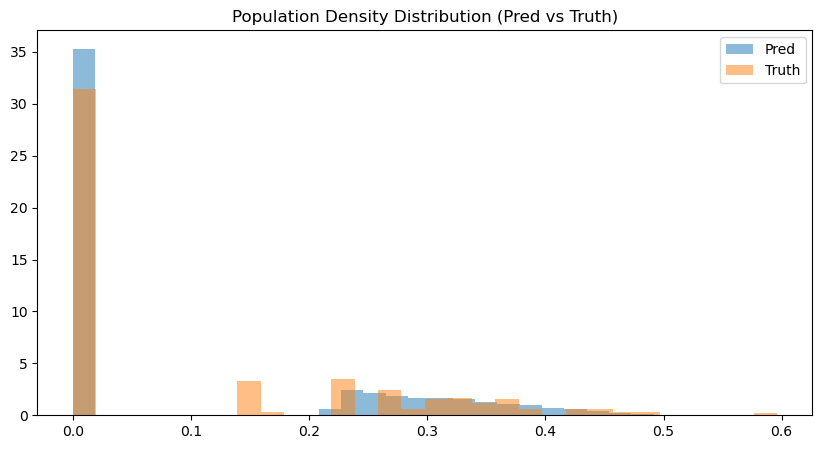

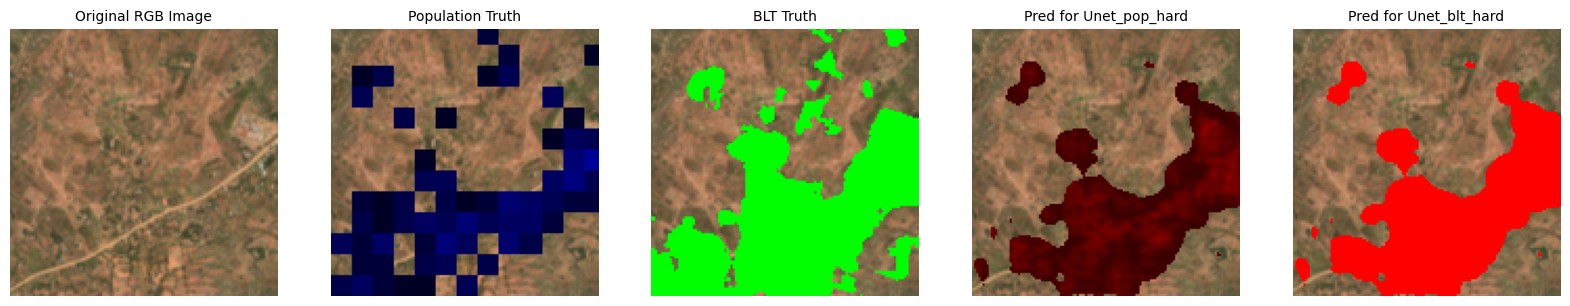

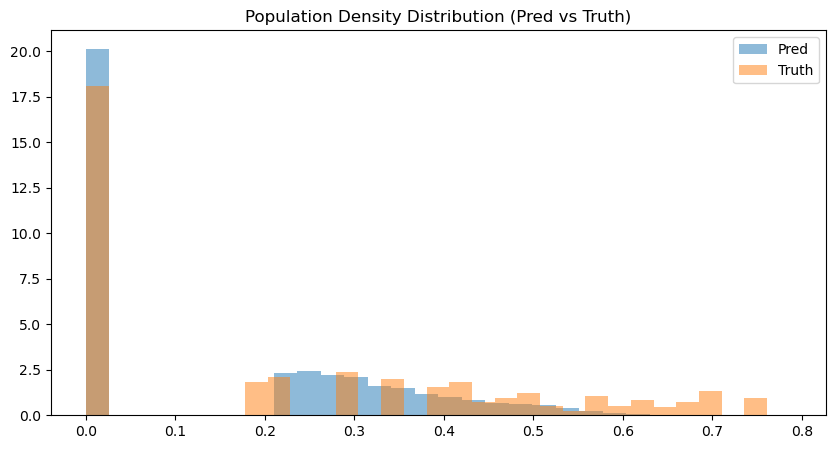

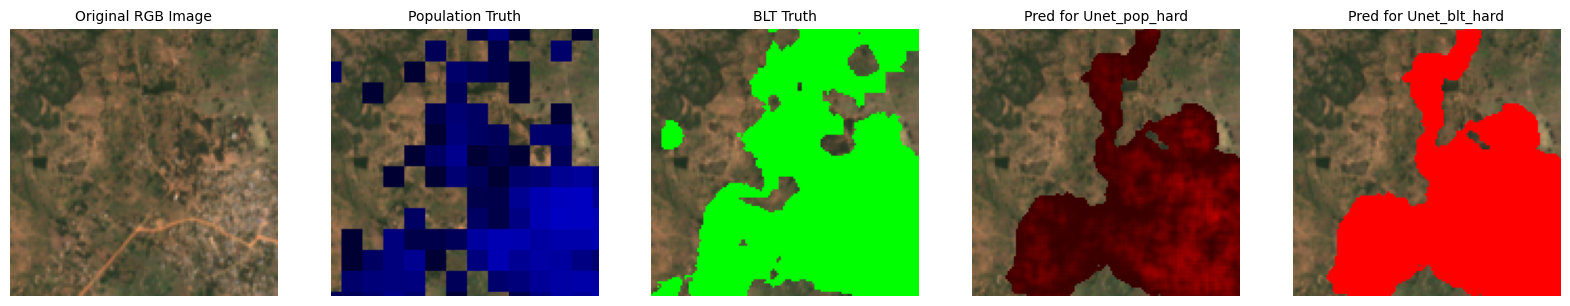

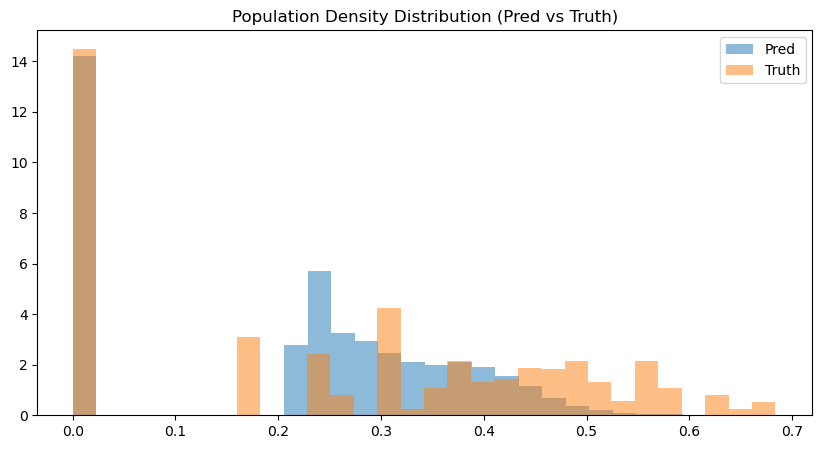

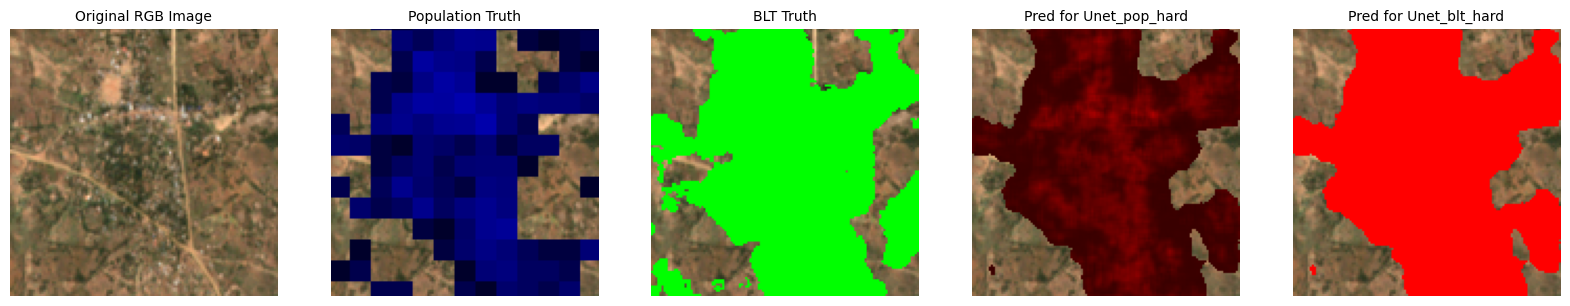

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
PATH1 = "saved_models/Unet_BLT_pretrained.pth"
PATH2 = "saved_models/Unet_pop_hard_early.pth"

blt_model = load_blt_model(Unet_BLT, PATH1, device, NUM_CHANNELS, NUM_CLASSES)
pop_model = load_pop_model(Unet_pop_2layer, PATH2, device, NUM_CHANNELS)

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_patch(pop_model, dataset_for_prediction, i, device, blt_model=blt_model, mask="Hard").detach().squeeze(0).squeeze(0).cpu().numpy()
    pred_blt = predict_on_blt_patch(blt_model, dataset_for_prediction, i, device)
    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()
    # clip negative values to 0
    pred[pred < 0] = 0

    # plot histogram of population density pred and truth
    plt.figure(figsize=(10, 5))
    plt.hist(pred.flatten(), bins=30, alpha=0.5, label="Pred", density=True)
    plt.hist(pop_truth.flatten(), bins=30, alpha=0.5, label="Truth", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=blt_truth, predictions=[pred, pred_blt], model_names = ['Unet_pop_hard', 'Unet_blt_hard'])


#### 4.3.3 Soft mask

In [14]:
dataset_soft = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.15, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)
train_dataset_soft = torch.utils.data.Subset(dataset_soft, list(set(range(len(dataset_soft))) - set(val_dataset_cloudfree.indices)))

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 40
pop_lr = 0.01
weight_decay = 0.0001
batch_size = 16

train_dataloader = DataLoader(train_dataset_soft, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader_cloudfree = DataLoader(val_training_dataset_cloudfree, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader_large = DataLoader(val_dataset_large, batch_size=batch_size, shuffle=False, num_workers=8)
PATH = "Unet_BLT_pretrained.pth"
blt_model = load_blt_model(Unet_BLT, PATH, device, NUM_CHANNELS, NUM_CLASSES)
pop_model = Unet_pop_2layer(NUM_CHANNELS)
blt_model.to(device)
pop_model.to(device)
pop_model = nn.DataParallel(pop_model)

weights = torch.tensor([1.0, 1.0]).to(device)  
blt_loss = nn.CrossEntropyLoss(weight=weights)
custom_mse_loss = nn.MSELoss() 
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
mae_weight = 0.01
mse_weight = 0.99
blt_weight = 1.0

pop_optimizer = torch.optim.Adam(pop_model.parameters(), lr=pop_lr, weight_decay=weight_decay)
pop_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pop_optimizer, mode='min', factor=0.5, patience=3)

train_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

val_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

best_val_loss = np.inf
best_pop_model = None
best_blt_model = None
best_epoch = 0

patience = 20


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_mae_train_loss, running_mse_train_loss, running_custom_mse_train = train_model(blt_model, pop_model, pop_optimizer, custom_mse_loss, mae_loss, mse_loss, train_dataloader, 
                                                                                                                                            device, blt_loss_func = blt_loss, mask="Soft", train_blt = False, mae_weight=mae_weight, 
                                                                                                                                             mse_weight=mse_weight)
    # Validate model
    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_cloudfree, device,  mask="Soft")

    # Validate model cloudy
    running_mae_val_loss_cloudy, running_mse_val_loss_cloudy, running_custom_mse_val_cloudy = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_large, device, mask="Soft")

    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = running_mae_val_loss + running_mae_val_loss_cloudy, running_mse_val_loss + running_mse_val_loss_cloudy, running_custom_mse_val + running_custom_mse_val_cloudy

 
    # Calculate epoch metrics
    epoch_mae_train_loss = running_mae_train_loss / len(train_dataloader)
    epoch_rmse_train_loss = np.sqrt(running_mse_train_loss / len(train_dataloader))
    epoch_custom_rmse_train_loss = np.sqrt(running_custom_mse_train / len(train_dataloader))

    epoch_mae_val_loss = running_mae_val_loss / (len(val_dataloader_cloudfree) + len(val_dataloader_large))
    epoch_rmse_val_loss = np.sqrt(running_mse_val_loss / (len(val_dataloader_cloudfree)  + len(val_dataloader_large)))
    epoch_custom_rmse_val_loss = np.sqrt(running_custom_mse_val / (len(val_dataloader_cloudfree) + len(val_dataloader_large)))

    epoch_loss = mae_weight * epoch_mae_val_loss + mse_weight * epoch_rmse_val_loss

     # Early stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss 
        best_pop_model = pop_model.state_dict().copy()
        best_blt_model = blt_model.state_dict().copy()
        best_epoch = epoch
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Udpate results dictionary
    train_results["mae_loss"].append(epoch_mae_train_loss)
    train_results["rmse"].append(epoch_rmse_train_loss)
    train_results["custom_rmse"].append(epoch_custom_rmse_train_loss)

    val_results["mae_loss"].append(epoch_mae_val_loss)
    val_results["rmse"].append(epoch_rmse_val_loss)
    val_results["custom_rmse"].append(epoch_custom_rmse_val_loss)

    # print results
    print(f"Epoch {epoch+1} train MAE: {epoch_mae_train_loss:.4f}, train RMSE: {epoch_rmse_train_loss:.4f}, train custom RMSE {epoch_custom_rmse_train_loss:.4f}, val MAE: {epoch_mae_val_loss:.4f}, val RMSE: {epoch_rmse_val_loss:.4f}, val custom RMSE {epoch_custom_rmse_val_loss:.4f}")

    # Update learning rate
    pop_scheduler.step(epoch_loss)
    print("Learning rate:", pop_scheduler._last_lr)

# Save model
#saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
PATH = f"Unet_pop_soft_early.pth"
torch.save(best_pop_model, PATH)

In [66]:
#plot_metrics(train_results, val_results)
print(f"Best epoch: {best_epoch+1}")
print(f"Best MAE: {val_results['mae_loss'][best_epoch]:.4f}")
print(f"Best RMSE: {val_results['rmse'][best_epoch]:.4f}")

Best epoch: 5
Best MAE: 0.0824
Best RMSE: 0.1358


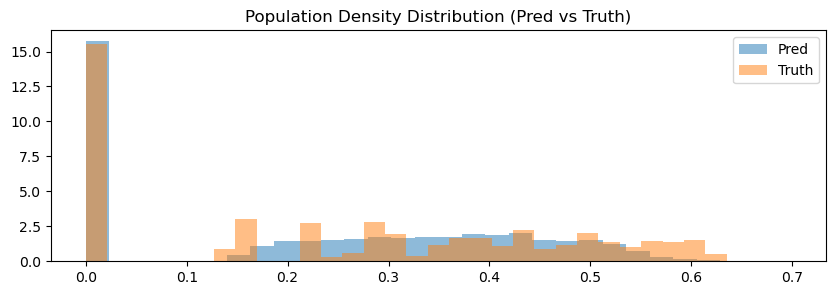

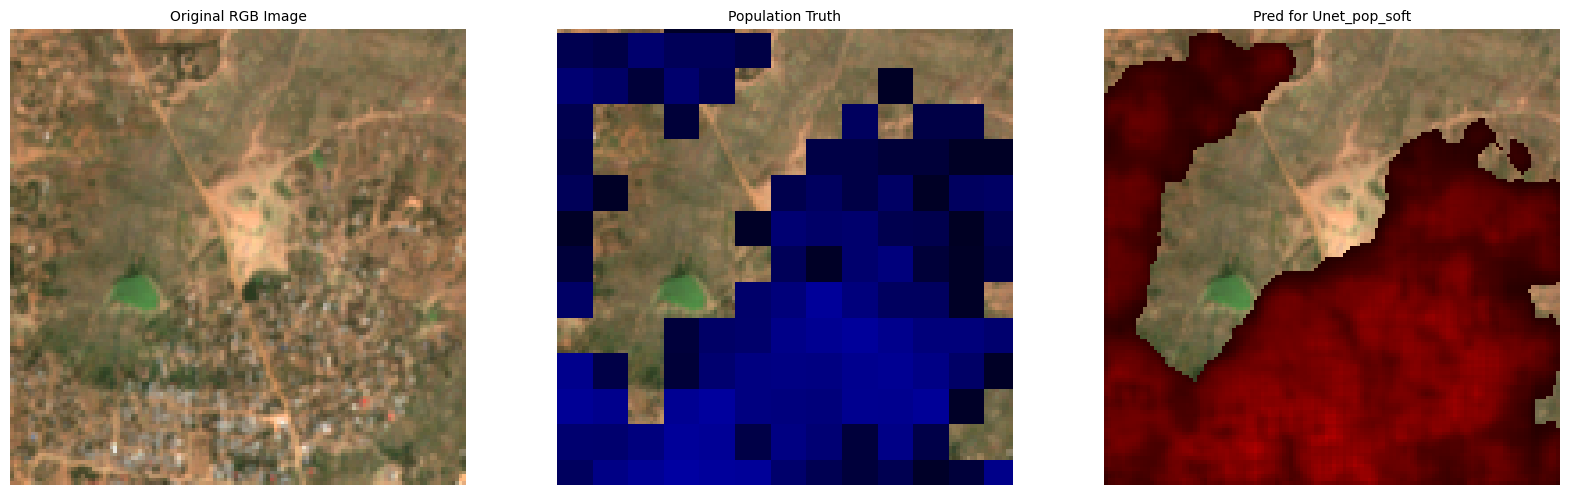

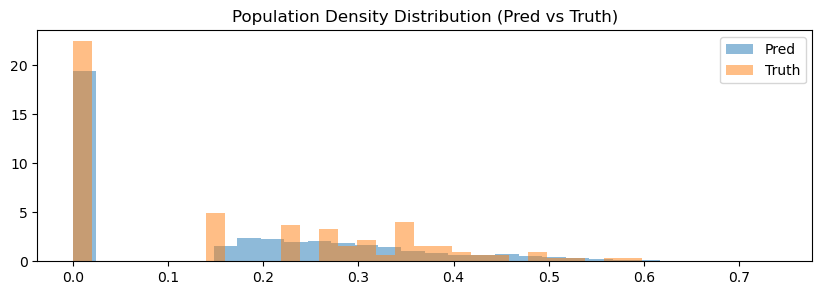

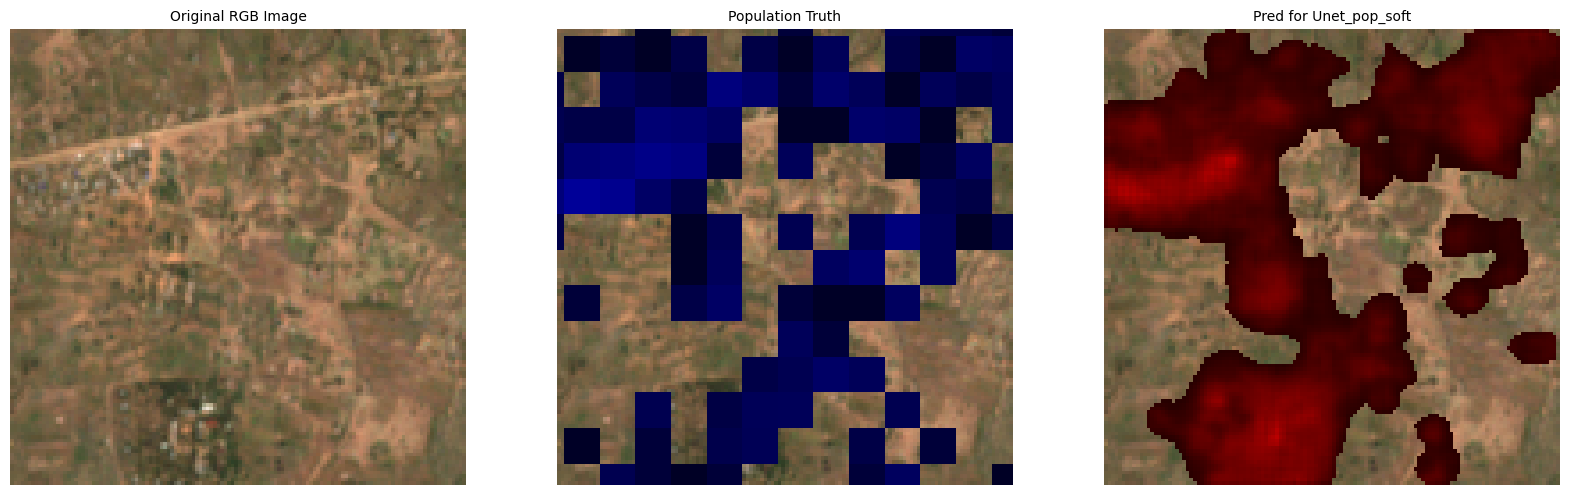

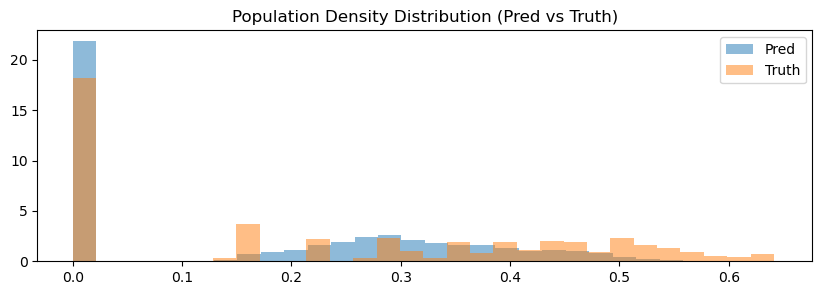

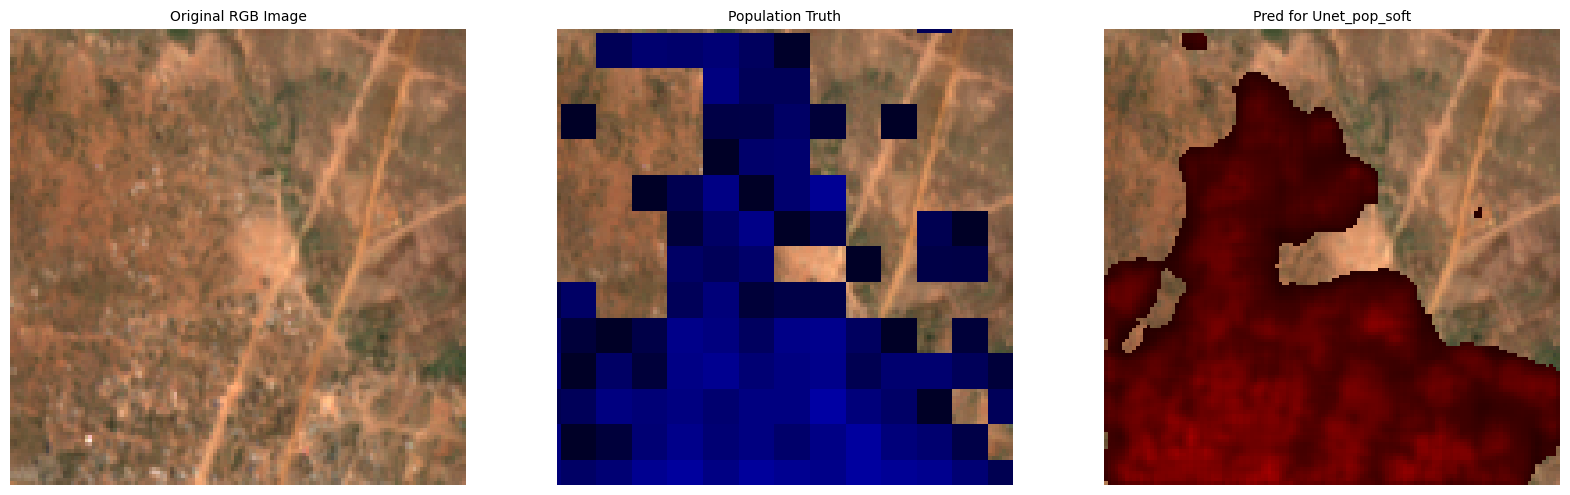

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
PATH1 = "saved_models/Unet_BLT_pretrained.pth"
PATH2 = "saved_models/Unet_pop_soft_early.pth"

blt_model = load_blt_model(Unet_BLT, PATH1, device, NUM_CHANNELS, NUM_CLASSES)
pop_model = load_pop_model(Unet_pop_2layer, PATH2, device, NUM_CHANNELS)

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_patch(pop_model, dataset_for_prediction, i, device, blt_model=blt_model, mask="Soft").detach().squeeze(0).squeeze(0).cpu().numpy()
    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    # plot histogram of population density pred and truth
    plt.figure(figsize=(10, 3))
    plt.hist(pred.flatten(), bins=30, alpha=0.5, label="Pred", density=True)
    plt.hist(pop_truth.flatten(), bins=30, alpha=0.5, label="Truth", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=None, predictions=[pred], model_names = ['Unet_pop_soft'])

### 4.4 Late fusion

#### 4.4.1 No mask

In [17]:
dataset_no_mask = Smoothed_H5Dataset(h5_files, blt_files, pop_files_scaled, file_name=file_names, patch_size=(128, 128), blt_threshold = 0.15, cloud_free=False, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)
train_dataset_no_mask = torch.utils.data.Subset(dataset_no_mask, list(set(range(len(dataset_no_mask))) - set(val_dataset_large.indices)))

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 30
pop_lr = 0.002
weight_decay = 0.0001
batch_size = 64

train_dataloader = DataLoader(train_dataset_no_mask, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
val_dataloader_cloudfree = DataLoader(val_training_dataset_cloudfree, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
val_dataloader_large = DataLoader(val_dataset_large, batch_size=batch_size, shuffle=False, num_workers=8)

blt_model = Unet_BLT(NUM_CHANNELS, NUM_CLASSES)
pop_model = Unet_pop_3layer(NUM_CHANNELS)
pop_model.to(device)
pop_model = nn.DataParallel(pop_model)
 
custom_mse_loss = nn.MSELoss() #CustomMSELoss(alpha=1.0, beta=0.5, gamma=0.0, near_zero_threshold=0.01, overprediction_threshold = 1.5).to(device)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
mae_weight = 0.05
mse_weight = 0.95

pop_optimizer = torch.optim.Adam(pop_model.parameters(), lr=pop_lr, weight_decay=weight_decay)
pop_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pop_optimizer, mode='min', factor=0.25, patience=5)

train_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

val_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

best_val_loss = np.inf
best_pop_model = None
best_epoch = 0

patience = 15


# Train model
for epoch in range(num_epochs):
    
    # train model
    running_mae_train_loss, running_mse_train_loss, running_custom_mse_train = train_model(blt_model, pop_model, pop_optimizer, custom_mse_loss, mae_loss, mse_loss, train_dataloader, 
                                                                                           device, mask = None, mae_weight=mae_weight, mse_weight=mse_weight)

    # Validate model cloud free
    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_cloudfree, device, mask=None)

    # Validate model cloudy
    running_mae_val_loss_cloudy, running_mse_val_loss_cloudy, running_custom_mse_val_cloudy = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_large, device, mask=None)

    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = running_mae_val_loss + running_mae_val_loss_cloudy, running_mse_val_loss + running_mse_val_loss_cloudy, running_custom_mse_val + running_custom_mse_val_cloudy

    # Calculate epoch metrics
    epoch_mae_train_loss = running_mae_train_loss / len(train_dataloader)
    epoch_rmse_train_loss = np.sqrt(running_mse_train_loss / len(train_dataloader))
    epoch_custom_rmse_train_loss = np.sqrt(running_custom_mse_train / len(train_dataloader))

    epoch_mae_val_loss = running_mae_val_loss / (len(val_dataloader_cloudfree) + len(val_dataloader_large))
    epoch_rmse_val_loss = np.sqrt(running_mse_val_loss / (len(val_dataloader_cloudfree)  + len(val_dataloader_large)))
    epoch_custom_rmse_val_loss = np.sqrt(running_custom_mse_val / (len(val_dataloader_cloudfree) + len(val_dataloader_large)))


    epoch_loss = mae_weight * epoch_mae_val_loss + mse_weight * epoch_rmse_val_loss

     # Early stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss 
        best_pop_model = pop_model.state_dict().copy()
        best_blt_model = blt_model.state_dict().copy()
        best_epoch = epoch
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Udpate results dictionary
    train_results["mae_loss"].append(epoch_mae_train_loss)
    train_results["rmse"].append(epoch_rmse_train_loss)
    train_results["custom_rmse"].append(epoch_custom_rmse_train_loss)

    val_results["mae_loss"].append(epoch_mae_val_loss)
    val_results["rmse"].append(epoch_rmse_val_loss)
    val_results["custom_rmse"].append(epoch_custom_rmse_val_loss)

    # print results
    print(f"Epoch {epoch+1} train MAE: {epoch_mae_train_loss:.4f}, train RMSE: {epoch_rmse_train_loss:.4f}, train custom RMSE {epoch_custom_rmse_train_loss:.4f}, val MAE: {epoch_mae_val_loss:.4f}, val RMSE: {epoch_rmse_val_loss:.4f}, val custom RMSE {epoch_custom_rmse_val_loss:.4f}")

    # Update learning rate
    pop_scheduler.step(epoch_loss)
    print("Learning rate:", pop_scheduler._last_lr)

# Save model
PATH = f"Unet_pop_no_mask_late.pth"
torch.save(best_pop_model, PATH)

In [31]:
print(f"Best epoch: {best_epoch+1}")
print(f"Best MAE: {val_results['mae_loss'][best_epoch]:.4f}")
print(f"Best RMSE: {val_results['rmse'][best_epoch]:.4f}")

Best epoch: 29
Best MAE: 0.1025
Best RMSE: 0.1324


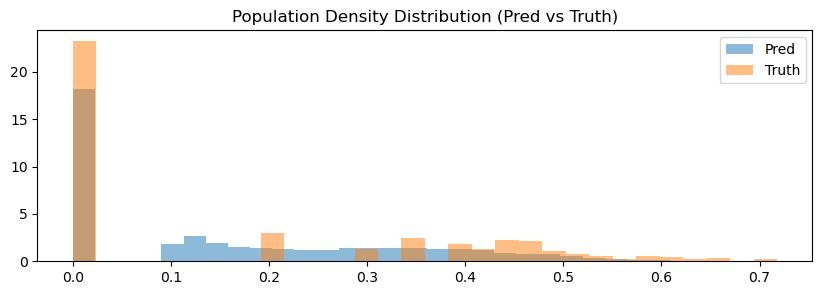

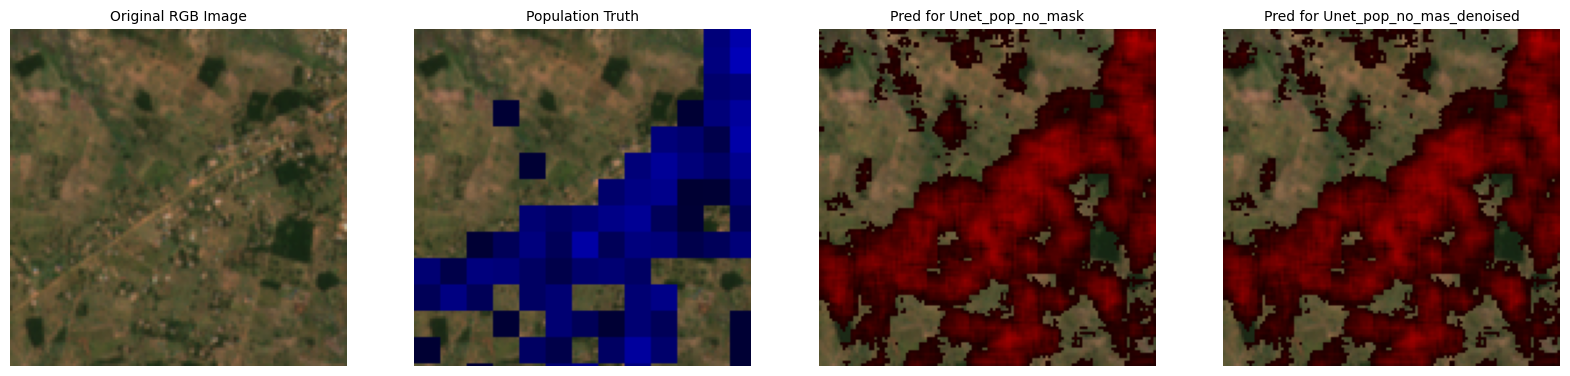

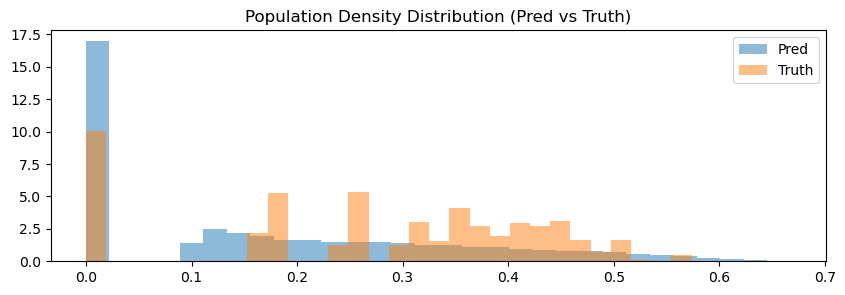

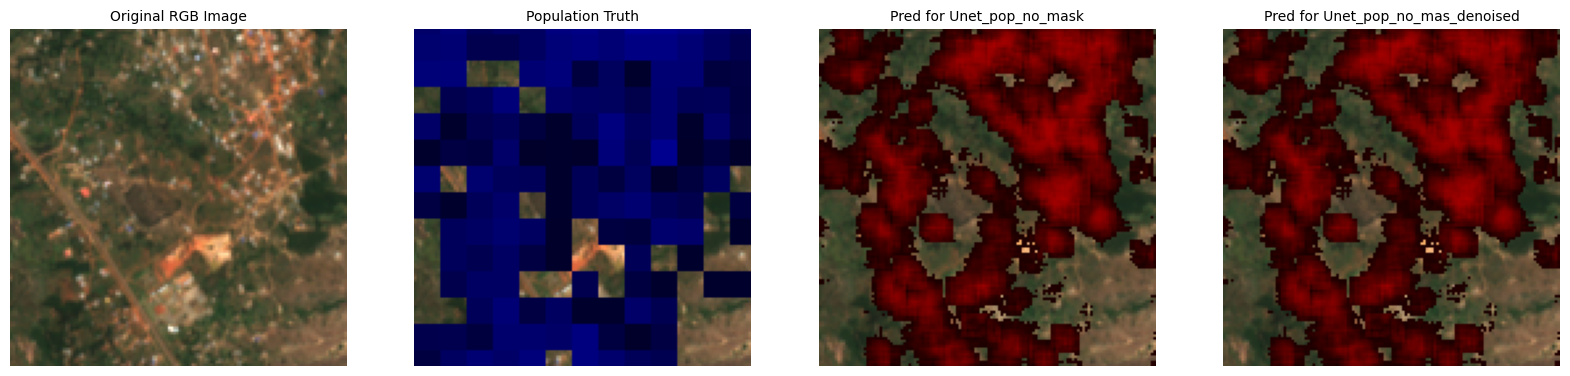

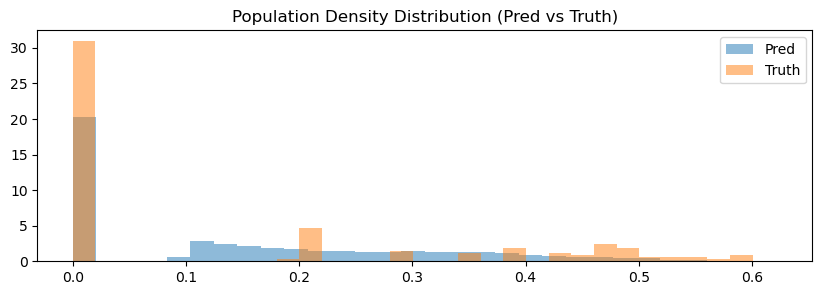

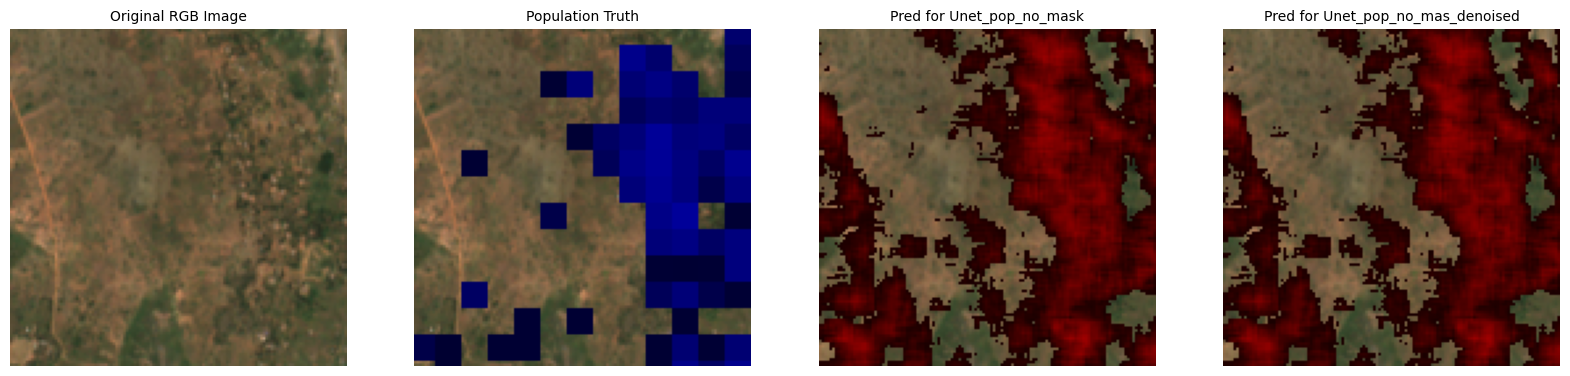

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
PATH2 = "saved_models/Unet_pop_no_mask_late.pth"
pop_model = load_pop_model(Unet_pop_3layer, PATH2, device, NUM_CHANNELS)

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_patch(pop_model, dataset_for_prediction, i, device, blt_model=None, mask=None).detach().squeeze(0).squeeze(0).cpu().numpy()
    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    # plot histogram of population density pred and truth
    plt.figure(figsize=(10, 3))
    plt.hist(pred.flatten(), bins=30, alpha=0.5, label="Pred", density=True)
    plt.hist(pop_truth.flatten(), bins=30, alpha=0.5, label="Truth", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    # create denoised version of prediction
    pred_denoised = np.copy(pred)
    bins = np.histogram(pred.flatten(), bins=30)[1]
    pred_denoised[pred_denoised <= bins[3]] = 0

    plot_with_overlays(rgb, pop_truth, blt=None, predictions=[pred, pred_denoised], model_names = ['Unet_pop_no_mask', 'Unet_pop_no_mas_denoised'])


#### 4.4.2 Hard mask

In [ ]:
dataset_hard = Smoothed_H5Dataset(h5_files, blt_files, pop_files_scaled, file_name=file_names, patch_size=(128, 128), blt_threshold = 0.1, cloud_free=False, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)
train_dataset_hard = torch.utils.data.Subset(dataset_hard, list(set(range(len(dataset_no_mask))) - set(val_dataset_large.indices)))

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
pop_lr = 0.01
weight_decay = 0.0001
batch_size = 64

train_dataloader = DataLoader(train_dataset_hard, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader_cloudfree = DataLoader(val_training_dataset_cloudfree, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader_large = DataLoader(val_dataset_large, batch_size=batch_size, shuffle=False, num_workers=8)
PATH = "Unet_BLT_pretrained.pth"
blt_model = load_blt_model(Unet_BLT, PATH, device, NUM_CHANNELS, NUM_CLASSES)
pop_model = Unet_pop_3layer(NUM_CHANNELS)
blt_model.to(device)
pop_model.to(device)
pop_model = nn.DataParallel(pop_model)

weights = torch.tensor([1.0, 1.0]).to(device)  
blt_loss = nn.CrossEntropyLoss(weight=weights)
custom_mse_loss = nn.MSELoss() #CustomMSELoss().to(device)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
mae_weight = 0.1
mse_weight = 0.9
blt_weight = 1.0

pop_optimizer = torch.optim.Adam(pop_model.parameters(), lr=pop_lr, weight_decay=weight_decay)
pop_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pop_optimizer, mode='min', factor=0.25, patience=3)

train_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

val_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

best_val_loss = np.inf
best_pop_model = None
best_blt_model = None
best_epoch = 0

patience = 15


# Train model
for epoch in range(num_epochs):
    

    # train model
    running_mae_train_loss, running_mse_train_loss, running_custom_mse_train = train_model(blt_model, pop_model, pop_optimizer, custom_mse_loss, mae_loss, mse_loss, train_dataloader, 
                                                                                             device, mask="Hard", mae_weight=mae_weight, mse_weight=mse_weight)
    # Validate model
    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_cloudfree, device,  mask="Hard")

    # Validate model cloudy
    running_mae_val_loss_cloudy, running_mse_val_loss_cloudy, running_custom_mse_val_cloudy = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_large, device, mask="Hard")

    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = running_mae_val_loss + running_mae_val_loss_cloudy, running_mse_val_loss + running_mse_val_loss_cloudy, running_custom_mse_val + running_custom_mse_val_cloudy

 
    # Calculate epoch metrics
    epoch_mae_train_loss = running_mae_train_loss / len(train_dataloader)
    epoch_rmse_train_loss = np.sqrt(running_mse_train_loss / len(train_dataloader))
    epoch_custom_rmse_train_loss = np.sqrt(running_custom_mse_train / len(train_dataloader))

    epoch_mae_val_loss = running_mae_val_loss / (len(val_dataloader_cloudfree) + len(val_dataloader_large))
    epoch_rmse_val_loss = np.sqrt(running_mse_val_loss / (len(val_dataloader_cloudfree)  + len(val_dataloader_large)))
    epoch_custom_rmse_val_loss = np.sqrt(running_custom_mse_val / (len(val_dataloader_cloudfree) + len(val_dataloader_large)))

    epoch_loss = mae_weight * epoch_mae_val_loss + mse_weight * epoch_rmse_val_loss

     # Early stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss 
        best_pop_model = pop_model.state_dict().copy()
        best_blt_model = blt_model.state_dict().copy()
        best_epoch = epoch
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Udpate results dictionary
    train_results["mae_loss"].append(epoch_mae_train_loss)
    train_results["rmse"].append(epoch_rmse_train_loss)
    train_results["custom_rmse"].append(epoch_custom_rmse_train_loss)

    val_results["mae_loss"].append(epoch_mae_val_loss)
    val_results["rmse"].append(epoch_rmse_val_loss)
    val_results["custom_rmse"].append(epoch_custom_rmse_val_loss)

    # print results
    print(f"Epoch {epoch+1} train MAE: {epoch_mae_train_loss:.4f}, train RMSE: {epoch_rmse_train_loss:.4f}, train custom RMSE {epoch_custom_rmse_train_loss:.4f}, val MAE: {epoch_mae_val_loss:.4f}, val RMSE: {epoch_rmse_val_loss:.4f}, val custom RMSE {epoch_custom_rmse_val_loss:.4f}")

    # Update learning rate
    pop_scheduler.step(epoch_loss)
    print("Learning rate:", pop_scheduler._last_lr)

# Save model
#saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
PATH1 = f"Unet_pop_hard.pth"
PATH2 = f"Unet_blt_hard.pth"
torch.save(best_pop_model, PATH1)
torch.save(best_blt_model, PATH2)

In [35]:
print(f"Best epoch: {best_epoch+1}")
print(f"Best MAE: {val_results['mae_loss'][best_epoch]:.4f}")
print(f"Best RMSE: {val_results['rmse'][best_epoch]:.4f}")

Best epoch: 36
Best MAE: 0.0744
Best RMSE: 0.1394


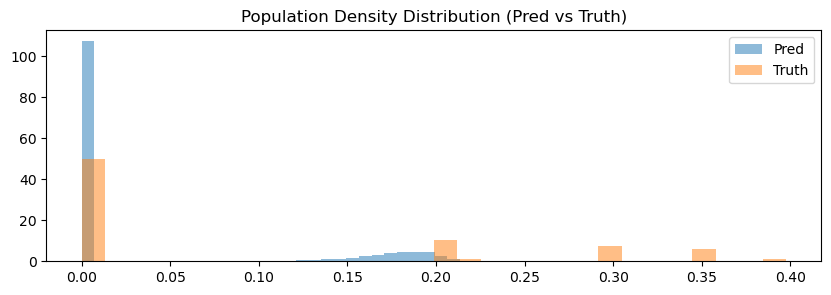

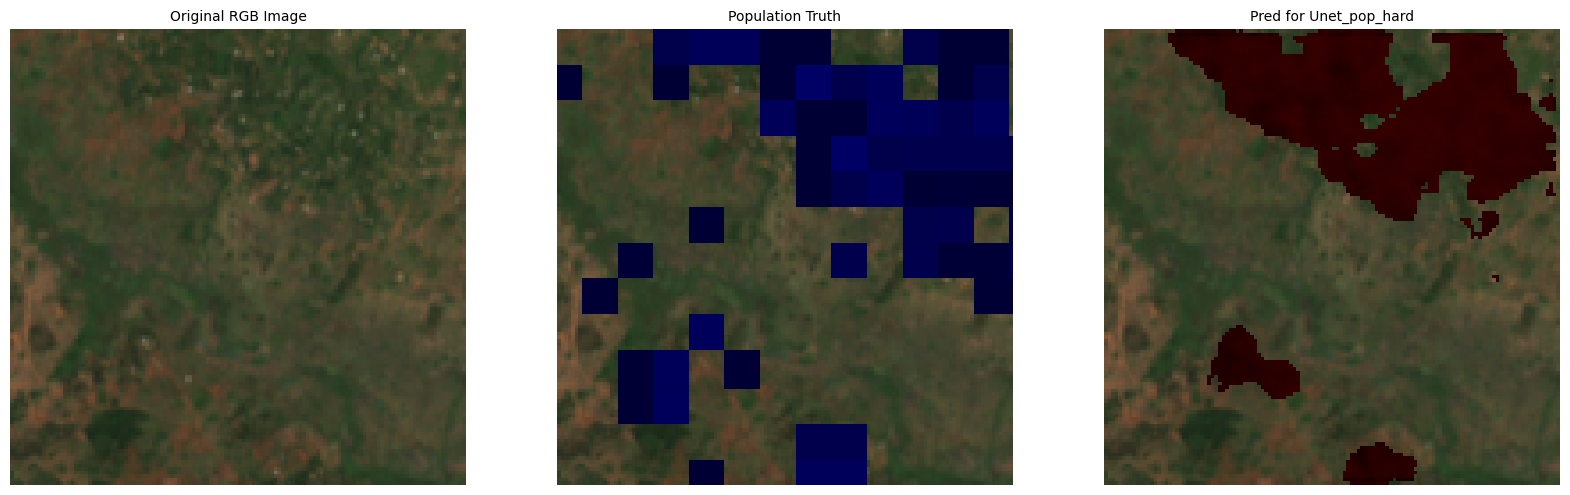

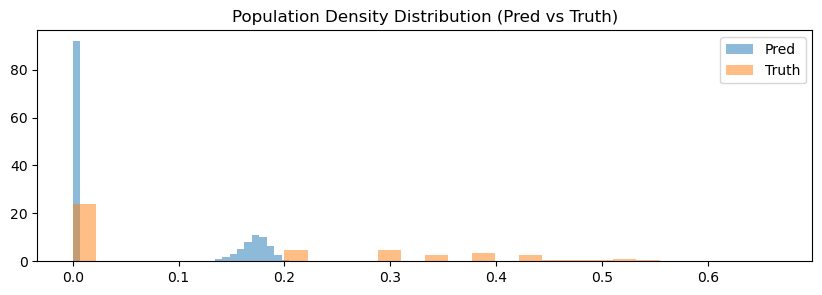

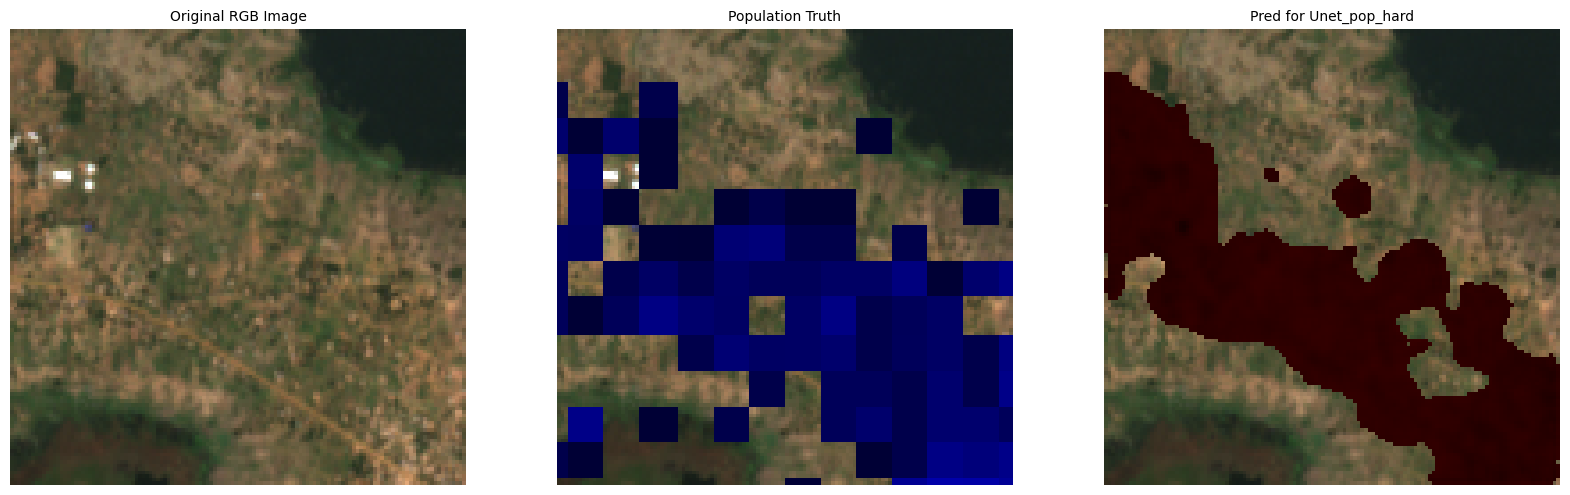

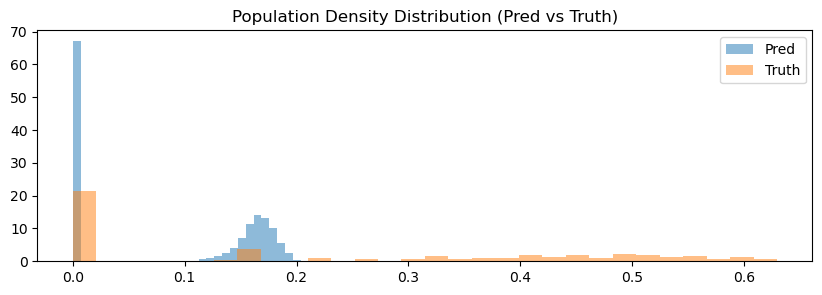

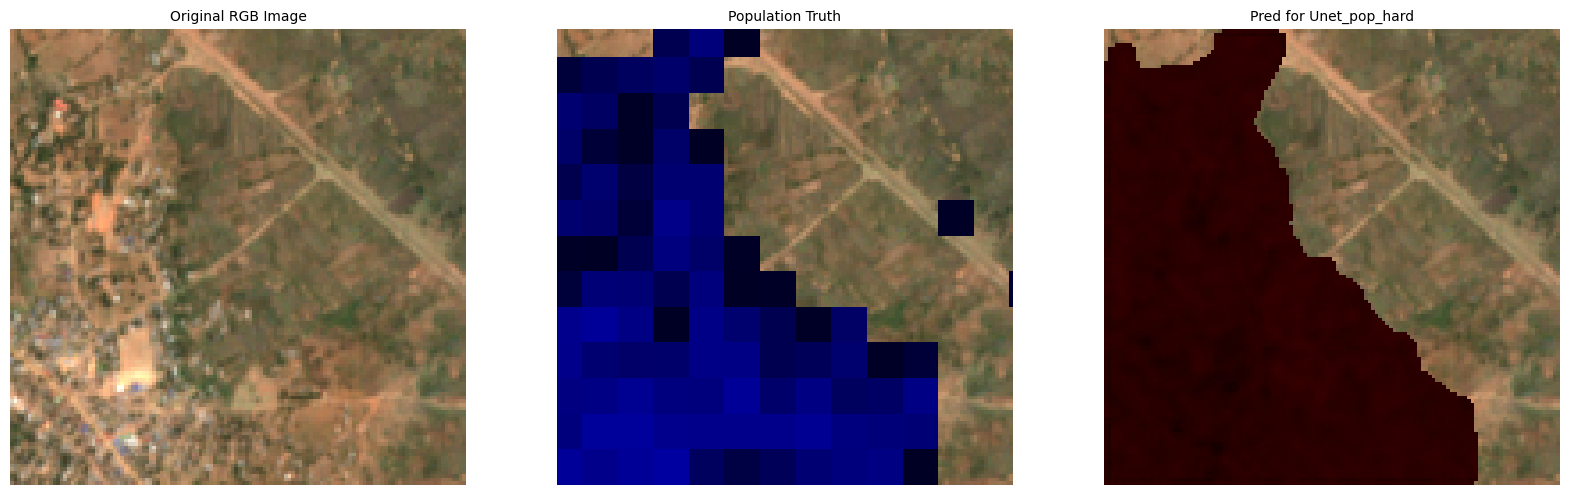

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
PATH1 = "saved_models/Unet_BLT_pretrained.pth"
PATH2 = "saved_models/Unet_pop_hard_late.pth"

blt_model = load_blt_model(Unet_BLT, PATH1, device, NUM_CHANNELS, NUM_CLASSES)
pop_model = load_pop_model(Unet_pop_3layer, PATH2, device, NUM_CHANNELS)

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_patch(pop_model, dataset_for_prediction, i, device, blt_model=blt_model, mask="Hard").detach().squeeze(0).squeeze(0).cpu().numpy()
    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()
    # clip negative values to 0
    pred[pred < 0] = 0

    # plot histogram of population density pred and truth
    plt.figure(figsize=(10, 3))
    plt.hist(pred.flatten(), bins=30, alpha=0.5, label="Pred", density=True)
    plt.hist(pop_truth.flatten(), bins=30, alpha=0.5, label="Truth", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=None, predictions=[pred], model_names = ['Unet_pop_hard'])


#### 4.4.3 Soft mask

In [69]:
dataset_soft = Smoothed_H5Dataset(h5_files, blt_files, pop_files_scaled, file_name=file_names, patch_size=(128, 128), blt_threshold = 0.15, cloud_free=False, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)
train_dataset_soft = torch.utils.data.Subset(dataset_soft, list(set(range(len(dataset_soft))) - set(val_dataset_cloudfree.indices)))

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4
NUM_CLASSES = 2

num_epochs = 50
pop_lr = 0.002
weight_decay = 0.0001
batch_size = 64

train_dataloader = DataLoader(train_dataset_hard, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader_cloudfree = DataLoader(val_training_dataset_cloudfree, batch_size=batch_size, shuffle=False, num_workers=8)
val_dataloader_large = DataLoader(val_dataset_large, batch_size=batch_size, shuffle=False, num_workers=8)
PATH = "Unet_BLT_pretrained.pth"
blt_model = load_blt_model(Unet_BLT, PATH, device, NUM_CHANNELS, NUM_CLASSES)
pop_model = Unet_pop_3layer(NUM_CHANNELS)
blt_model.to(device)
pop_model.to(device)
pop_model = nn.DataParallel(pop_model)

weights = torch.tensor([1.0, 1.0]).to(device)  
blt_loss = nn.CrossEntropyLoss(weight=weights)
custom_mse_loss = nn.MSELoss() # CustomMSELoss(alpha=1.0, beta=0.0, gamma=3.0, near_zero_threshold=0.01, overprediction_threshold = 1.3).to(device)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
mae_weight = 0.01
mse_weight = 0.99
blt_weight = 1.0

pop_optimizer = torch.optim.Adam(pop_model.parameters(), lr=pop_lr, weight_decay=weight_decay)
pop_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pop_optimizer, mode='min', factor=0.25, patience=3)

train_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

val_results = {
    "mae_loss": [],
    "rmse": [],
    "custom_rmse": []
}

best_val_loss = np.inf
best_pop_model = None
best_blt_model = None
best_epoch = 0

patience = 15


# Train model
for epoch in range(num_epochs):
    

    # train model
    running_mae_train_loss, running_mse_train_loss, running_custom_mse_train = train_model(blt_model, pop_model, pop_optimizer, custom_mse_loss, mae_loss, mse_loss, train_dataloader, 
                                                                                             device, mask="Soft", mae_weight=mae_weight, mse_weight=mse_weight)
    # Validate model
    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_cloudfree, device,  mask="Soft")

    # Validate model cloudy
    running_mae_val_loss_cloudy, running_mse_val_loss_cloudy, running_custom_mse_val_cloudy = validate_model(blt_model, pop_model, custom_mse_loss, mae_loss, mse_loss, val_dataloader_large, device, mask="Soft")

    running_mae_val_loss, running_mse_val_loss, running_custom_mse_val = running_mae_val_loss + running_mae_val_loss_cloudy, running_mse_val_loss + running_mse_val_loss_cloudy, running_custom_mse_val + running_custom_mse_val_cloudy

 
    # Calculate epoch metrics
    epoch_mae_train_loss = running_mae_train_loss / len(train_dataloader)
    epoch_rmse_train_loss = np.sqrt(running_mse_train_loss / len(train_dataloader))
    epoch_custom_rmse_train_loss = np.sqrt(running_custom_mse_train / len(train_dataloader))

    epoch_mae_val_loss = running_mae_val_loss / (len(val_dataloader_cloudfree) + len(val_dataloader_large))
    epoch_rmse_val_loss = np.sqrt(running_mse_val_loss / (len(val_dataloader_cloudfree)  + len(val_dataloader_large)))
    epoch_custom_rmse_val_loss = np.sqrt(running_custom_mse_val / (len(val_dataloader_cloudfree) + len(val_dataloader_large)))

    epoch_loss = mae_weight * epoch_mae_val_loss + mse_weight * epoch_rmse_val_loss

     # Early stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss 
        best_pop_model = pop_model.state_dict().copy()
        best_blt_model = blt_model.state_dict().copy()
        best_epoch = epoch
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Udpate results dictionary
    train_results["mae_loss"].append(epoch_mae_train_loss)
    train_results["rmse"].append(epoch_rmse_train_loss)
    train_results["custom_rmse"].append(epoch_custom_rmse_train_loss)

    val_results["mae_loss"].append(epoch_mae_val_loss)
    val_results["rmse"].append(epoch_rmse_val_loss)
    val_results["custom_rmse"].append(epoch_custom_rmse_val_loss)

    # print results
    print(f"Epoch {epoch+1} train MAE: {epoch_mae_train_loss:.4f}, train RMSE: {epoch_rmse_train_loss:.4f}, train custom RMSE {epoch_custom_rmse_train_loss:.4f}, val MAE: {epoch_mae_val_loss:.4f}, val RMSE: {epoch_rmse_val_loss:.4f}, val custom RMSE {epoch_custom_rmse_val_loss:.4f}")

    # Update learning rate
    pop_scheduler.step(epoch_loss)
    print("Learning rate:", pop_scheduler._last_lr)

# Save model
#saved_f1 = np.round(val_results["val_f1_score"][np.argmin(val_results["val_loss"])], 2)
PATH1 = f"Unet_pop_soft.pth"
PATH2 = f"Unet_blt_soft.pth"
torch.save(best_pop_model, PATH1)
torch.save(best_blt_model, PATH2)

In [73]:
print(f"Best epoch: {best_epoch+1}")
print(f"Best MAE: {val_results['mae_loss'][best_epoch]:.4f}")
print(f"Best RMSE: {val_results['rmse'][best_epoch]:.4f}")

Best epoch: 29
Best MAE: 0.0745
Best RMSE: 0.1299


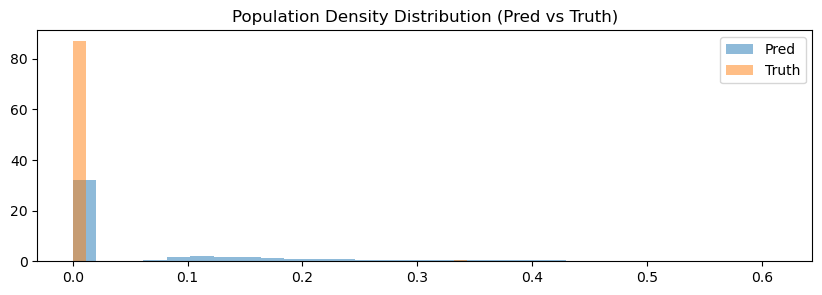

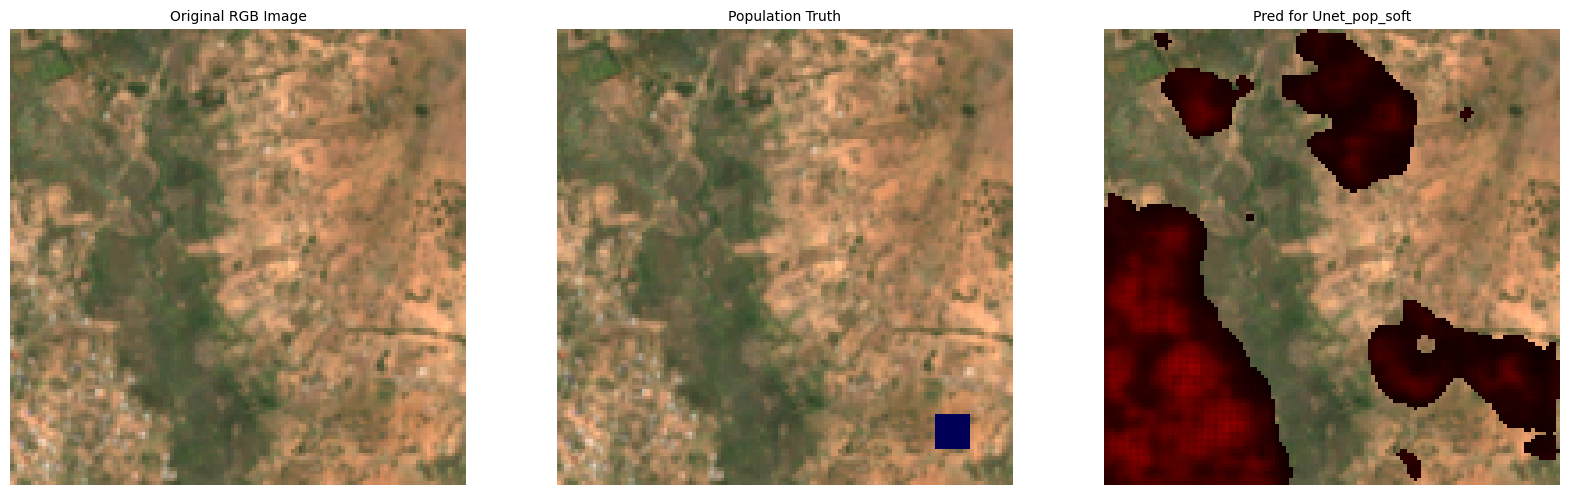

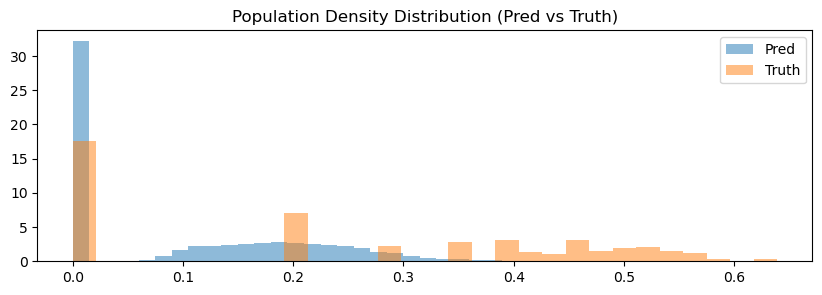

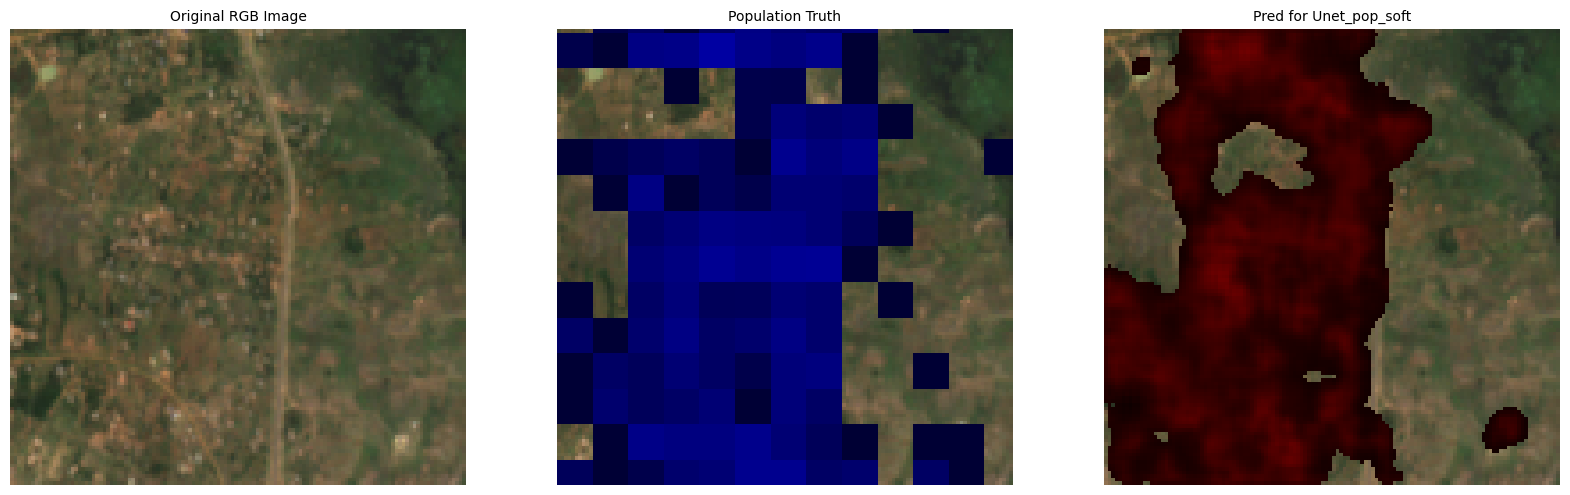

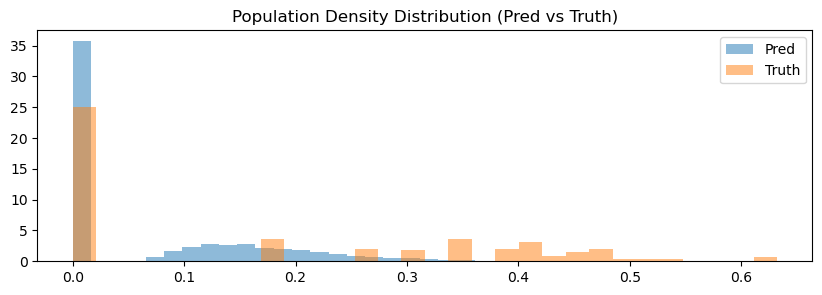

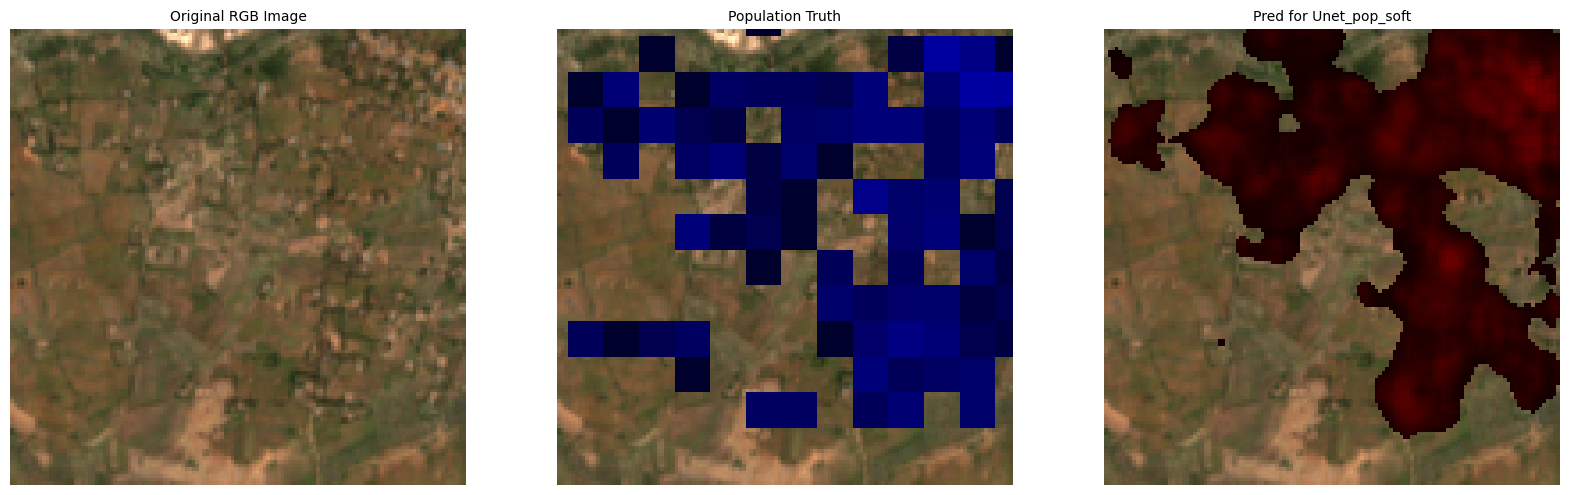

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CHANNELS = 4
NUM_CLASSES = 2
PATH1 = "saved_models/Unet_BLT_pretrained.pth"
PATH2 = "saved_models/Unet_pop_soft_late.pth"

blt_model = load_blt_model(Unet_BLT, PATH1, device, NUM_CHANNELS, NUM_CLASSES)
pop_model = load_pop_model(Unet_pop_3layer, PATH2, device, NUM_CHANNELS)

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()
    pred = predict_on_patch(pop_model, dataset_for_prediction, i, device, blt_model=blt_model, mask="Soft").detach().squeeze(0).squeeze(0).cpu().numpy()
    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    # plot histogram of population density pred and truth
    plt.figure(figsize=(10, 3))
    plt.hist(pred.flatten(), bins=30, alpha=0.5, label="Pred", density=True)
    plt.hist(pop_truth.flatten(), bins=30, alpha=0.5, label="Truth", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=None, predictions=[pred], model_names = ['Unet_pop_soft'])

### 4.5 Comparing built-up effect

#### 4.5.1 Within early fusion

In [ ]:
# Comparing built-up effect on early fusion

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

NUM_CHANNELS = 4
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_indices = random.sample(range(len(dataset_seperated)), 50)

# Load models
blt_model_pretrained = load_blt_model(Unet_BLT, "Unet_BLT_pretrained.pth", device, NUM_CHANNELS, NUM_CLASSES)
pop_model_no_mask_early = load_pop_model(Unet_pop_2layer, "Unet_pop_no_mask_early.pth", device, NUM_CHANNELS)
pop_model_hard_early = load_pop_model(Unet_pop_2layer, "Unet_pop_hard_early.pth", device, NUM_CHANNELS)
pop_model_soft_early = load_pop_model(Unet_pop_2layer, "Unet_pop_soft_early.pth", device, NUM_CHANNELS)

# Create list of models and masks
pop_models = [pop_model_no_mask_early, pop_model_hard_early, pop_model_soft_early]
masks = [None, "Hard", "Soft"]

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()

    pred_pop = []
    for idx, (model, mask) in enumerate(zip(pop_models, masks)):
        pred = predict_on_patch(model, dataset_for_prediction, i, device, blt_model=blt_model_pretrained, mask=mask).detach().squeeze(0).squeeze(0).cpu().numpy()
        pred_pop.append(np.array(pred))

    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    bins = np.histogram(pop_truth, bins=30)[1]
    plt.hist(pop_truth.flatten(), bins=bins, alpha=0.3, label="Truth", density=True)
    for idx, (pred, mask) in enumerate(zip(pred_pop, masks)):
        # make list of predictions into array
        #pred = np.array(pred)
        plt.hist(pred.flatten(), bins=bins, alpha=0.3, label=f"Mask: {mask}", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=blt_truth, predictions=pred_pop, model_names = ['pop_no_mask_early', 'pop_hard_early', 'pop_soft_early'])

#### 4.5.2 Within late fusion

In [ ]:
# Comparing built-up effect on early fusion

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

NUM_CHANNELS = 4
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_indices = random.sample(range(len(dataset_seperated)), 50)

# Load models
blt_model_pretrained = load_blt_model(Unet_BLT, "Unet_BLT_pretrained.pth", device, NUM_CHANNELS, NUM_CLASSES)
pop_model_no_mask_early = load_pop_model(Unet_pop_3layer, "Unet_pop_no_mask_late.pth", device, NUM_CHANNELS)
pop_model_hard_early = load_pop_model(Unet_pop_3layer, "Unet_pop_hard_late.pth", device, NUM_CHANNELS)
pop_model_soft_early = load_pop_model(Unet_pop_3layer, "Unet_pop_soft_late.pth", device, NUM_CHANNELS)

# Create list of models and masks
pop_models = [pop_model_no_mask_early, pop_model_hard_early, pop_model_soft_early]
masks = [None, "Hard", "Soft"]

random_indices = random.sample(range(len(dataset_seperated)), 50)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()

    pred_pop = []
    for idx, (model, mask) in enumerate(zip(pop_models, masks)):
        pred = predict_on_patch(model, dataset_for_prediction, i, device, blt_model=blt_model_pretrained, mask=mask).detach().squeeze(0).squeeze(0).cpu().numpy()
        pred_pop.append(np.array(pred))

    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    bins = np.histogram(pop_truth, bins=30)[1]
    plt.hist(pop_truth.flatten(), bins=bins, alpha=0.3, label="Truth", density=True)
    for idx, (pred, mask) in enumerate(zip(pred_pop, masks)):
        # make list of predictions into array
        #pred = np.array(pred)
        plt.hist(pred.flatten(), bins=bins, alpha=0.3, label=f"Mask: {mask}", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=blt_truth, predictions=pred_pop, model_names = ['Unet_pop_no_mask_late', 'pop_hard_late', 'pop_soft_late'])

### 4.6 Comparing fusion

In [ ]:
# Comparing built-up effect on early fusion

dataset_seperated = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_files_cloudfree, blt_files_cloudfree, pop_files_scaled_cloudfree, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

# reduce dataset to patches that are also in val_pretraining_dataset
dataset_seperated = torch.utils.data.Subset(dataset_seperated, val_training_dataset_cloudfree.indices)
dataset_for_prediction = torch.utils.data.Subset(dataset_for_prediction, val_training_dataset_cloudfree.indices)

NUM_CHANNELS = 4
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_indices = random.sample(range(len(dataset_seperated)), 50)

# Load models
blt_model_pretrained = load_blt_model(Unet_BLT, "Unet_BLT_pretrained.pth", device, NUM_CHANNELS, NUM_CLASSES)
pop_model_soft_early = load_pop_model(Unet_pop_2layer, "Unet_pop_soft_early.pth", device, NUM_CHANNELS)
pop_model_soft_late = load_pop_model(Unet_pop_3layer, "Unet_pop_soft_late.pth", device, NUM_CHANNELS)

# Create list of models and masks
pop_models = [pop_model_soft_early, pop_model_soft_late]
masks = ["Soft Early", "Soft Late"]

random_indices = random.sample(range(len(dataset_seperated)), 20)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()

    pred_pop = []
    for idx, (model, mask) in enumerate(zip(pop_models, masks)):
        pred = predict_on_patch(model, dataset_for_prediction, i, device, blt_model=blt_model_pretrained, mask="Soft").detach().squeeze(0).squeeze(0).cpu().numpy()
        pred_pop.append(np.array(pred))

    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    bins = np.histogram(pop_truth, bins=30)[1]
    plt.hist(pop_truth.flatten(), bins=bins, alpha=0.3, label="Truth", density=True)
    for idx, (pred, mask) in enumerate(zip(pred_pop, masks)):
        # make list of predictions into array
        #pred = np.array(pred)
        plt.hist(pred.flatten(), bins=bins, alpha=0.3, label=f"Mask: {mask}", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=blt_truth, predictions=pred_pop, model_names = ['pop_soft_early', 'pop_soft_late'])

## 5. Testing

### 5.1 Cloudfree image

#### 5.1.1 Metrices

In [ ]:
h5_DAR_cloudfree = ["/home/pf/pfstud/mlarriere/aligned_data/DAR_aligned_cldmedian.h5"]
blt_DAR = ["/home/pf/pfstud/mlarriere/aligned_data/DAR_aligned_BLT.h5"]
pop_DAR = ["/home/pf/pfstud/mlarriere/aligned_data/pop_density/DAR_aligned_scaled.h5"]
file_names_cloudfree = {'RGB': 'RGB_cldmedian', 'NIR': 'NIR_cldmedian'}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#----CustomDataset----
test_dataset = Smoothed_H5Dataset(h5_DAR_cloudfree, blt_DAR, pop_DAR, file_name=file_names_cloudfree, patch_size=(128, 128), blt_threshold = 0.0, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)

#----DataLoader----
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

num_batches = len(test_loader) #number of batches
total_objects = len(test_loader.dataset)#number of objects
print("Number of batches:", num_batches)
print("Total number of objects:", total_objects)

#----MODEL----
NUM_CHANNELS = 4
NUM_CLASSES = 2

custom_mse_loss = nn.MSELoss() 
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
mae_weight = 0.01
mse_weight = 0.99

#----LOAD MODEL----

blt_model_pretrained = load_blt_model(Unet_BLT, "saved_models/Unet_BLT_pretrained.pth", device, NUM_CHANNELS, NUM_CLASSES)
pop_model_no_mask_early = load_pop_model(Unet_pop_2layer, "saved_models/Unet_pop_no_mask_early.pth", device, NUM_CHANNELS)
pop_model_hard_early = load_pop_model(Unet_pop_2layer, "saved_models/Unet_pop_hard_early.pth", device, NUM_CHANNELS)
pop_model_soft_early = load_pop_model(Unet_pop_2layer, "saved_models/Unet_pop_soft_early.pth", device, NUM_CHANNELS)

pop_model_no_mask_late = load_pop_model(Unet_pop_3layer, "saved_models/Unet_pop_no_mask_late.pth", device, NUM_CHANNELS)
pop_model_hard_late = load_pop_model(Unet_pop_3layer, "saved_models/Unet_pop_hard_late.pth", device, NUM_CHANNELS)
pop_model_soft_late = load_pop_model(Unet_pop_3layer, "saved_models/Unet_pop_soft_late.pth", device, NUM_CHANNELS)

#----PREDICT----
mae_test_no_mask_early, mse_test_no_mask_early, custom_mse_test_no_mask_early = validate_model(blt_model_pretrained, pop_model_no_mask_early, custom_mse_loss, mae_loss, mse_loss, test_loader, device, mask=None)
mae_test_no_mask_early, mse_test_no_mask_early, custom_mse_test_no_mask_early = mae_test_no_mask_early / len(test_loader), mse_test_no_mask_early / len(test_loader), custom_mse_test_no_mask_early / len(test_loader)
mae_test_hard_early, mse_test_hard_early, custom_mse_test_hard_early = validate_model(blt_model_pretrained, pop_model_hard_early, custom_mse_loss, mae_loss, mse_loss, test_loader, device, mask="Hard")
mae_test_hard_early, mse_test_hard_early, custom_mse_test_hard_early = mae_test_hard_early / len(test_loader), mse_test_hard_early / len(test_loader), custom_mse_test_hard_early / len(test_loader)
mae_test_soft_early, mse_test_soft_early, custom_mse_test_soft_early = validate_model(blt_model_pretrained, pop_model_soft_early, custom_mse_loss, mae_loss, mse_loss, test_loader, device, mask="Soft")
mae_test_soft_early, mse_test_soft_early, custom_mse_test_soft_early = mae_test_soft_early / len(test_loader), mse_test_soft_early / len(test_loader), custom_mse_test_soft_early / len(test_loader)

mae_test_no_mask_late, mse_test_no_mask_late, custom_mse_test_no_mask_late = validate_model(blt_model_pretrained, pop_model_no_mask_late, custom_mse_loss, mae_loss, mse_loss, test_loader, device, mask=None)
mae_test_no_mask_late, mse_test_no_mask_late, custom_mse_test_no_mask_late = mae_test_no_mask_late / len(test_loader), mse_test_no_mask_late / len(test_loader), custom_mse_test_no_mask_late / len(test_loader)
mae_test_hard_late, mse_test_hard_late, custom_mse_test_hard_late = validate_model(blt_model_pretrained, pop_model_hard_late, custom_mse_loss, mae_loss, mse_loss, test_loader, device, mask="Hard")
mae_test_hard_late, mse_test_hard_late, custom_mse_test_hard_late = mae_test_hard_late / len(test_loader), mse_test_hard_late / len(test_loader), custom_mse_test_hard_late / len(test_loader)
mae_test_soft_late, mse_test_soft_late, custom_mse_test_soft_late = validate_model(blt_model_pretrained, pop_model_soft_late, custom_mse_loss, mae_loss, mse_loss, test_loader, device, mask="Soft") 
mae_test_soft_late, mse_test_soft_late, custom_mse_test_soft_late = mae_test_soft_late / len(test_loader), mse_test_soft_late / len(test_loader), custom_mse_test_soft_late / len(test_loader)

# Print results
print(f"No_mask_early: MAE: {mae_test_no_mask_early:.4f}, RMSE: {np.sqrt(mse_test_no_mask_early):.4f}")
print(f"Hard_early: MAE: {mae_test_hard_early:.4f}, RMSE: {np.sqrt(mse_test_hard_early):.4f}")
print(f"Soft_early: MAE: {mae_test_soft_early:.4f}, RMSE: {np.sqrt(mse_test_soft_early):.4f}")

print(f"No_mask_late: MAE: {mae_test_no_mask_late:.4f}, RMSE: {np.sqrt(mse_test_no_mask_late):.4f}")
print(f"Hard_late: MAE: {mae_test_hard_late:.4f}, RMSE: {np.sqrt(mse_test_hard_late):.4f}")
print(f"Soft_late: MAE: {mae_test_soft_late:.4f}, RMSE: {np.sqrt(mse_test_soft_late):.4f}")

#### 5.1.2 Comparing built-up effect within early fusion

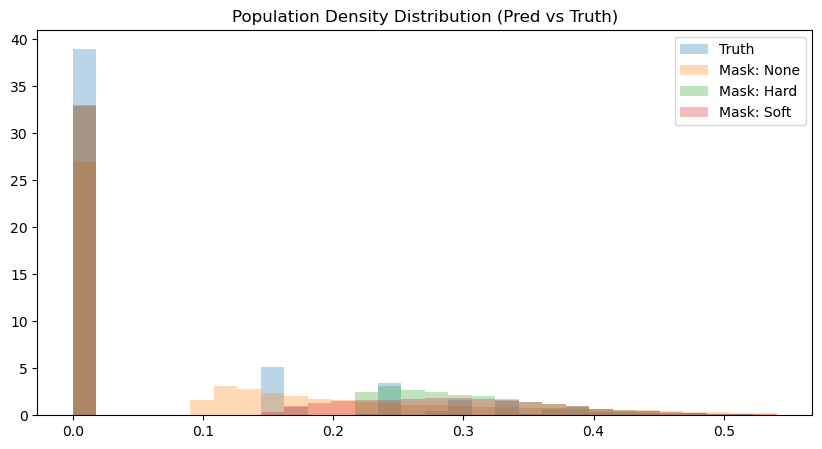

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


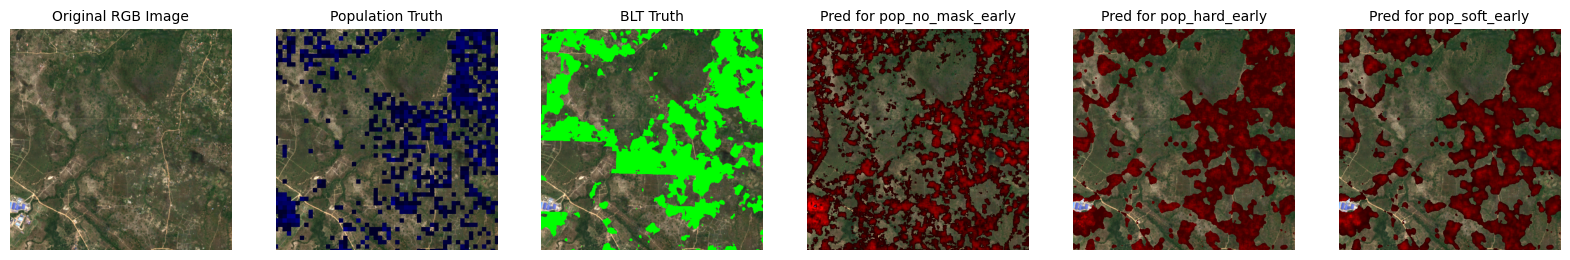

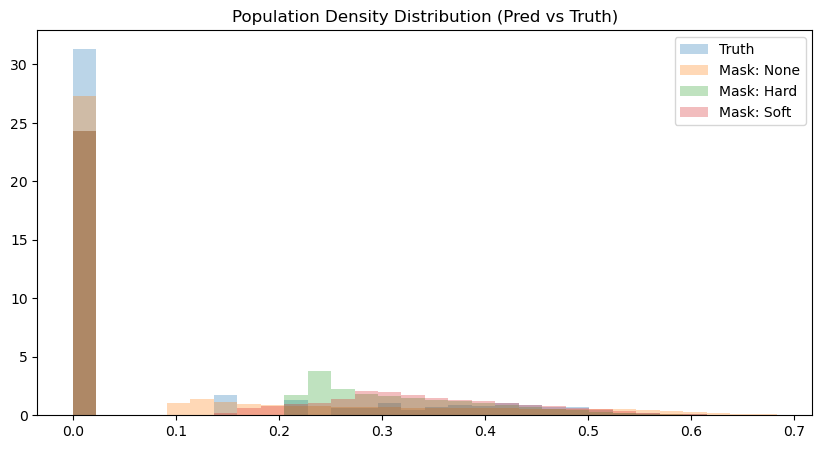

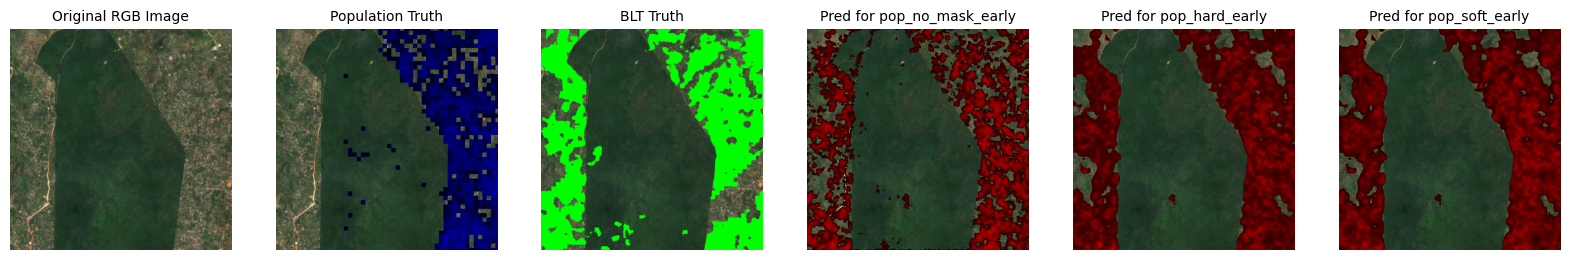

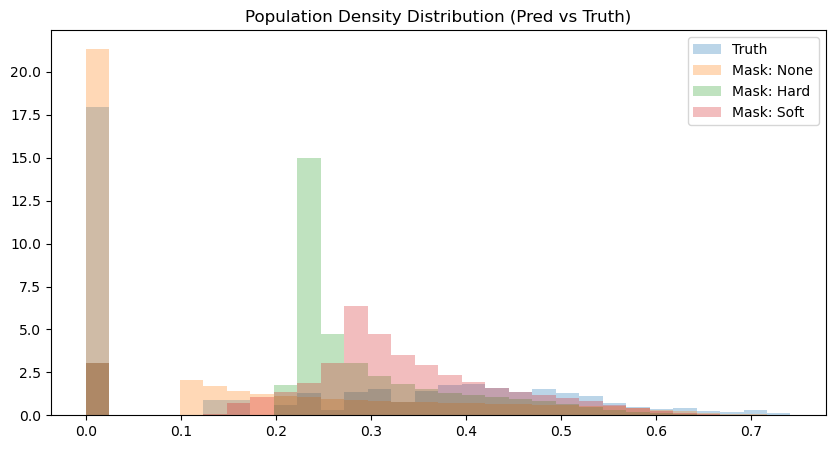

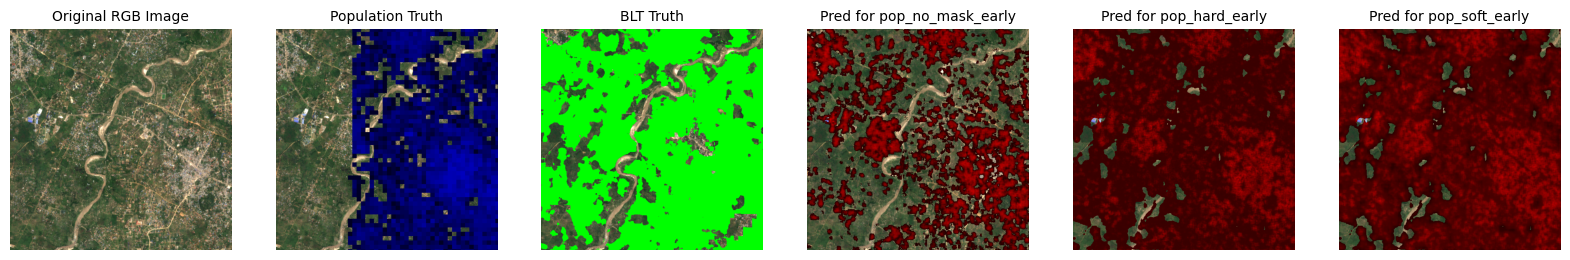

In [10]:
# Comparing built-up effect on early fusion

dataset_seperated = Smoothed_H5Dataset(h5_DAR_cloudfree, blt_DAR, pop_DAR, file_name=file_names_cloudfree, patch_size=(512, 512), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_DAR_cloudfree, blt_DAR, pop_DAR, file_name=file_names_cloudfree, patch_size=(512, 512), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)


NUM_CHANNELS = 4
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
blt_model_pretrained = load_blt_model(Unet_BLT, "saved_models/Unet_BLT_pretrained.pth", device, NUM_CHANNELS, NUM_CLASSES)
pop_model_no_mask_early = load_pop_model(Unet_pop_2layer, "saved_models/Unet_pop_no_mask_early.pth", device, NUM_CHANNELS)
pop_model_hard_early = load_pop_model(Unet_pop_2layer, "saved_models/Unet_pop_hard_early.pth", device, NUM_CHANNELS)
pop_model_soft_early = load_pop_model(Unet_pop_2layer, "saved_models/Unet_pop_soft_early.pth", device, NUM_CHANNELS)

# Create list of models and masks
pop_models = [pop_model_no_mask_early, pop_model_hard_early, pop_model_soft_early]
masks = [None, "Hard", "Soft"]

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()

    pred_pop = []
    for idx, (model, mask) in enumerate(zip(pop_models, masks)):
        pred = predict_on_patch(model, dataset_for_prediction, i, device, blt_model=blt_model_pretrained, mask=mask).detach().squeeze(0).squeeze(0).cpu().numpy()
        pred_pop.append(np.array(pred))

    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    bins = np.histogram(pop_truth, bins=30)[1]
    plt.hist(pop_truth.flatten(), bins=bins, alpha=0.3, label="Truth", density=True)
    for idx, (pred, mask) in enumerate(zip(pred_pop, masks)):
        # make list of predictions into array
        #pred = np.array(pred)
        plt.hist(pred.flatten(), bins=bins, alpha=0.3, label=f"Mask: {mask}", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=blt_truth, predictions=pred_pop, model_names = ['pop_no_mask_early', 'pop_hard_early', 'pop_soft_early'])

#### 5.1.3 Comparing built-up effect within late fusion

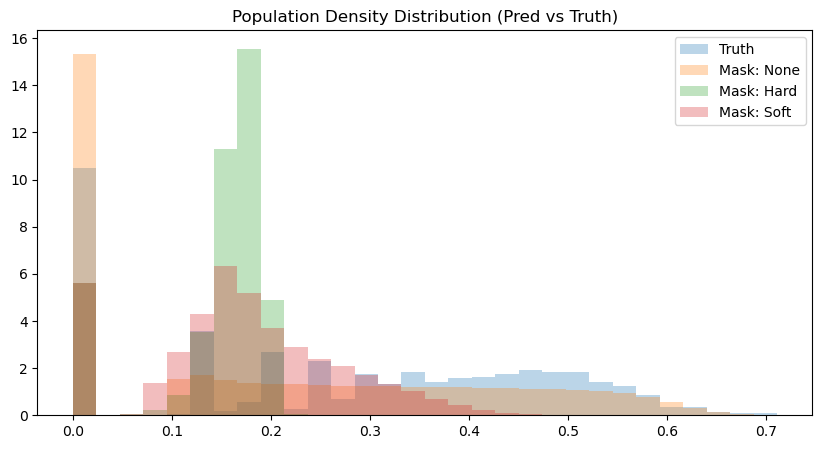

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


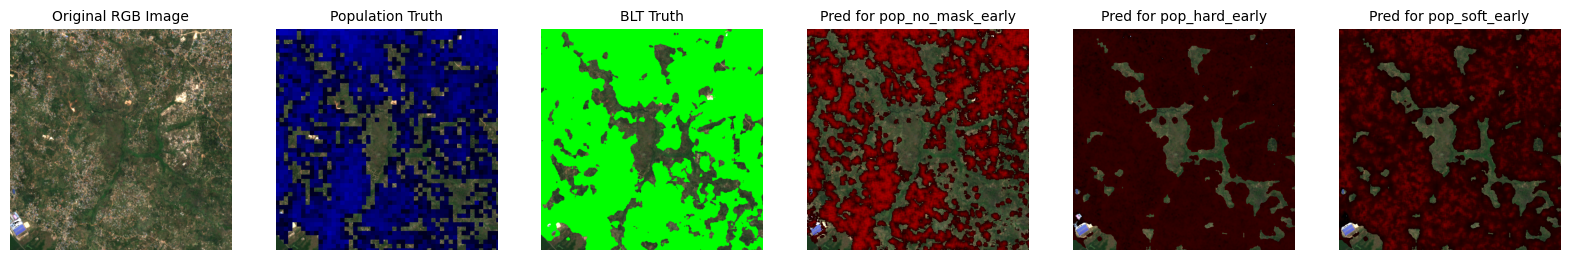

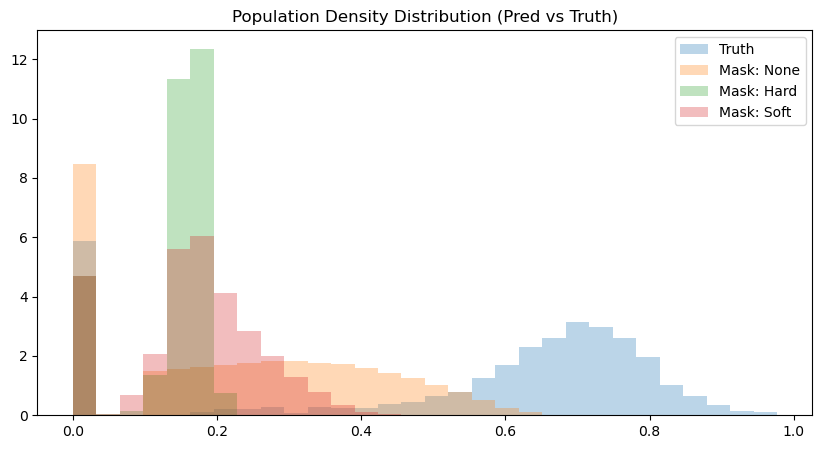

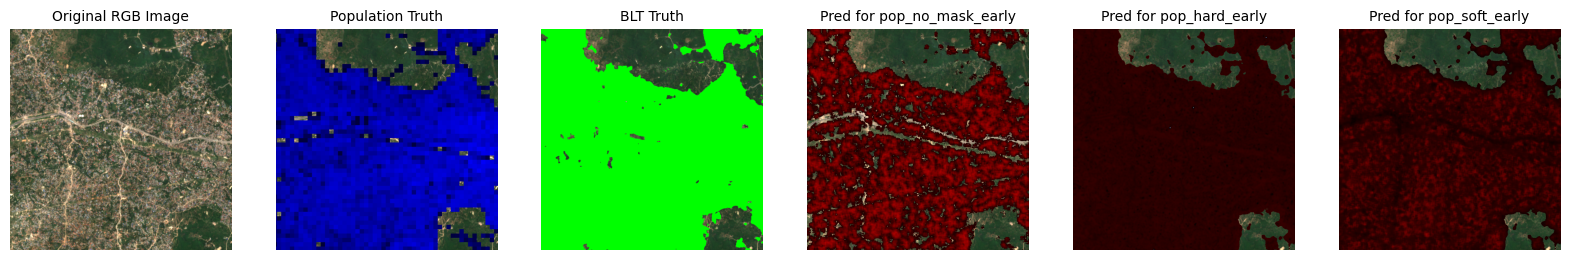

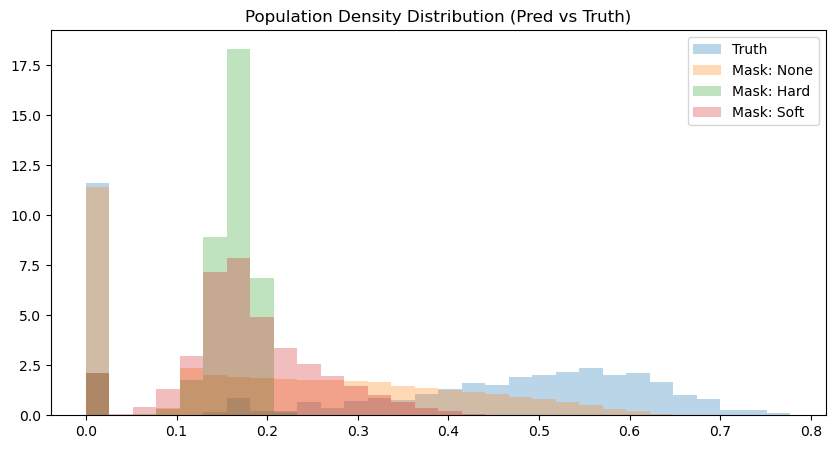

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


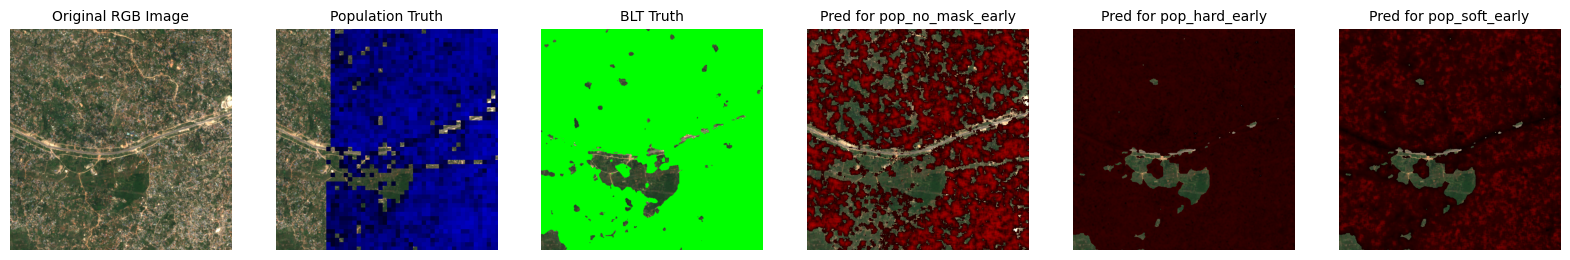

In [11]:
# Comparing built-up effect on early fusion

dataset_seperated = Smoothed_H5Dataset(h5_DAR_cloudfree, blt_DAR, pop_DAR, file_name=file_names_cloudfree, patch_size=(512, 512), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_DAR_cloudfree, blt_DAR, pop_DAR, file_name=file_names_cloudfree, patch_size=(512, 512), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)


NUM_CHANNELS = 4
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
blt_model_pretrained = load_blt_model(Unet_BLT, "saved_models/Unet_BLT_pretrained.pth", device, NUM_CHANNELS, NUM_CLASSES)
pop_model_no_mask_late = load_pop_model(Unet_pop_3layer, "saved_models/Unet_pop_no_mask_late.pth", device, NUM_CHANNELS)
pop_model_hard_late = load_pop_model(Unet_pop_3layer, "saved_models/Unet_pop_hard_late.pth", device, NUM_CHANNELS)
pop_model_soft_late = load_pop_model(Unet_pop_3layer, "saved_models/Unet_pop_soft_late.pth", device, NUM_CHANNELS)

# Create list of models and masks
pop_models = [pop_model_no_mask_late, pop_model_hard_late, pop_model_soft_late]
masks = [None, "Hard", "Soft"]

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()

    pred_pop = []
    for idx, (model, mask) in enumerate(zip(pop_models, masks)):
        pred = predict_on_patch(model, dataset_for_prediction, i, device, blt_model=blt_model_pretrained, mask=mask).detach().squeeze(0).squeeze(0).cpu().numpy()
        pred_pop.append(np.array(pred))

    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    bins = np.histogram(pop_truth, bins=30)[1]
    plt.hist(pop_truth.flatten(), bins=bins, alpha=0.3, label="Truth", density=True)
    for idx, (pred, mask) in enumerate(zip(pred_pop, masks)):
        # make list of predictions into array
        #pred = np.array(pred)
        plt.hist(pred.flatten(), bins=bins, alpha=0.3, label=f"Mask: {mask}", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=blt_truth, predictions=pred_pop, model_names = ['pop_no_mask_early', 'pop_hard_early', 'pop_soft_early'])


#### 5.1.4 Comparing fusion

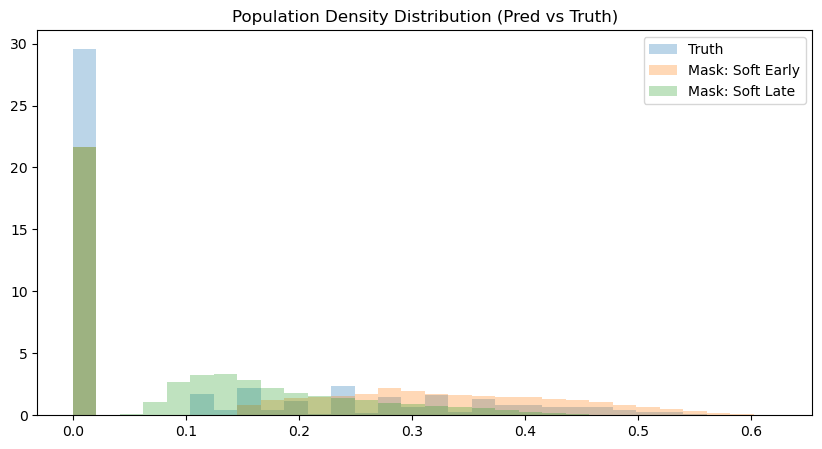

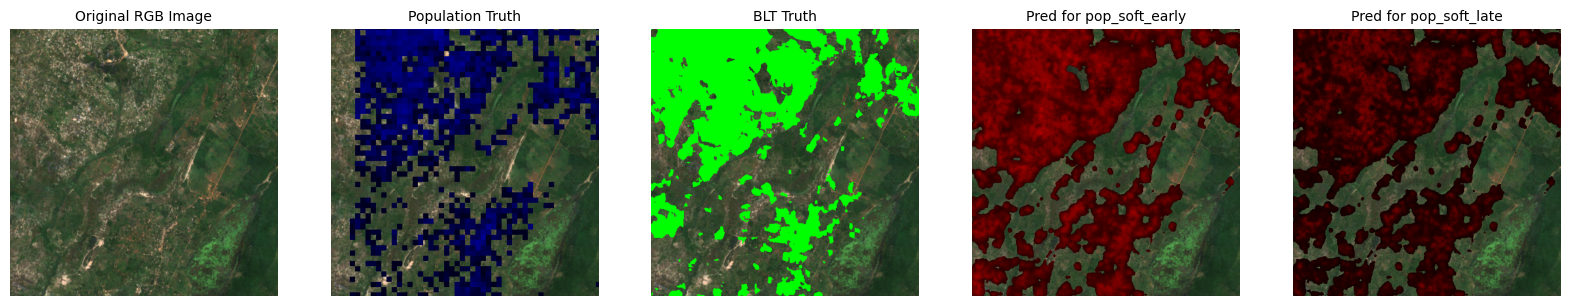

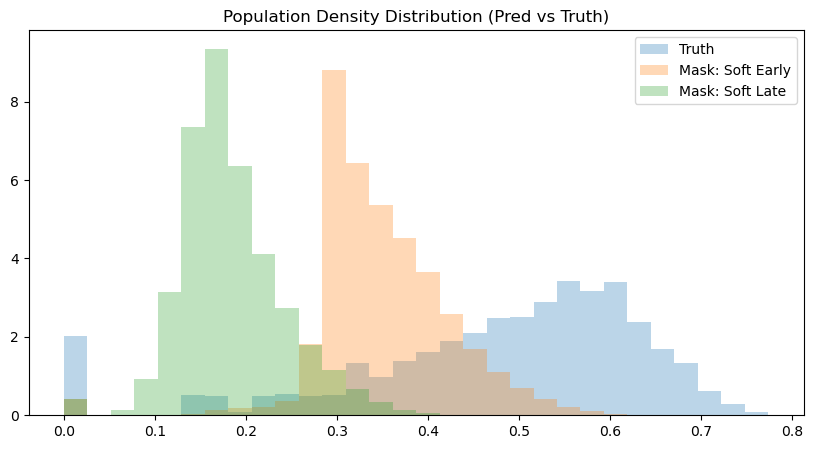

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


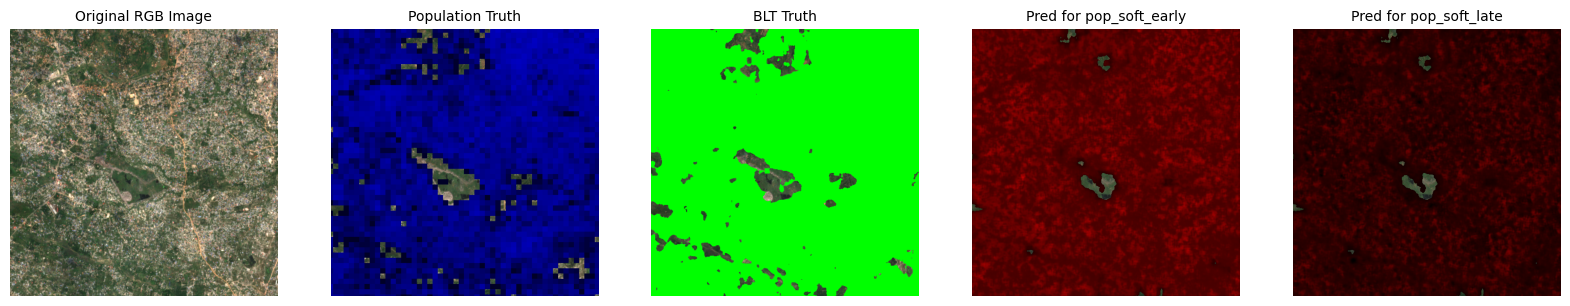

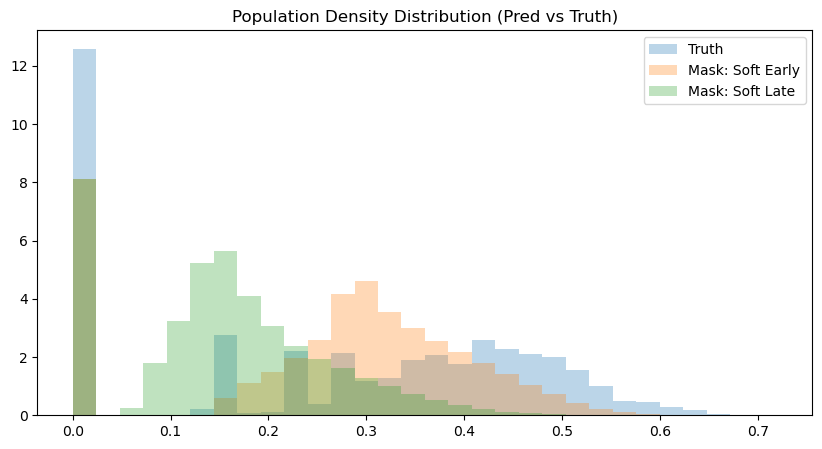

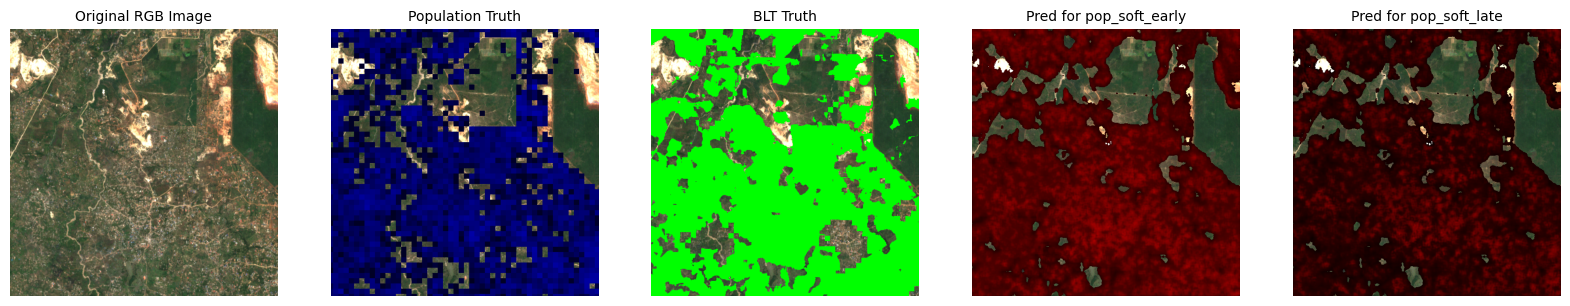

In [14]:
# Comparing built-up effect on early fusion

dataset_seperated = Smoothed_H5Dataset(h5_DAR_cloudfree, blt_DAR, pop_DAR, file_name=file_names_cloudfree, patch_size=(512, 512), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=True, log=True, augment=False, num_augment=1)
dataset_for_prediction = Smoothed_H5Dataset(h5_DAR_cloudfree, blt_DAR, pop_DAR, file_name=file_names_cloudfree, patch_size=(512, 512), blt_threshold = 0.3, cloud_free=True, return_rgb_nir_separately=False, log=True, augment=False, num_augment=1)


NUM_CHANNELS = 4
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
blt_model_pretrained = load_blt_model(Unet_BLT, "saved_models/Unet_BLT_pretrained.pth", device, NUM_CHANNELS, NUM_CLASSES)
pop_model_soft_early = load_pop_model(Unet_pop_2layer, "saved_models/Unet_pop_soft_early.pth", device, NUM_CHANNELS)
pop_model_soft_late = load_pop_model(Unet_pop_3layer, "saved_models/Unet_pop_soft_late.pth", device, NUM_CHANNELS)

# Create list of models and masks
pop_models = [pop_model_soft_early, pop_model_soft_late]
masks = ["Soft Early", "Soft Late"]

random_indices = random.sample(range(len(dataset_seperated)), 3)

for i in random_indices:
    rgb = dataset_seperated[i][0].permute(1, 2, 0).numpy()

    pred_pop = []
    for idx, (model, mask) in enumerate(zip(pop_models, masks)):
        pred = predict_on_patch(model, dataset_for_prediction, i, device, blt_model=blt_model_pretrained, mask="Soft").detach().squeeze(0).squeeze(0).cpu().numpy()
        pred_pop.append(np.array(pred))

    pop_truth = dataset_for_prediction[i][2].squeeze(0).cpu().numpy()
    blt_truth = dataset_for_prediction[i][1].squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    bins = np.histogram(pop_truth, bins=30)[1]
    plt.hist(pop_truth.flatten(), bins=bins, alpha=0.3, label="Truth", density=True)
    for idx, (pred, mask) in enumerate(zip(pred_pop, masks)):
        # make list of predictions into array
        #pred = np.array(pred)
        plt.hist(pred.flatten(), bins=bins, alpha=0.3, label=f"Mask: {mask}", density=True)
    plt.title("Population Density Distribution (Pred vs Truth)")
    plt.legend()
    plt.show()
    
    plot_with_overlays(rgb, pop_truth, blt=blt_truth, predictions=pred_pop, model_names = ['pop_soft_early', 'pop_soft_late'])
